<a href="https://colab.research.google.com/github/kwonionsoup/Analyze-International-Debt-Statistics/blob/master/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Customer Churn: A Logistic Regression Analysis in Telecom Industry


- Objective: To develop a predictive model using logistic regression that identifies the likelihood of a telecom company's customers either continuing with their current services ("staying") or discontinuing them ("churning"). The goal is to understand the key factors influencing customer retention and churn.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.metrics import log_loss
from scipy.stats import chi2

In [3]:

# Load the dataset
file_path = '/content/drive/MyDrive/telecom_customer_churn.csv'
data = pd.read_csv(file_path)

data_info = data.info()
data_head = data.head()

data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              7043 non-null   objec

(None,
   Customer ID  Gender  Age Married  Number of Dependents          City  \
 0  0002-ORFBO  Female   37     Yes                     0  Frazier Park   
 1  0003-MKNFE    Male   46      No                     0      Glendale   
 2  0004-TLHLJ    Male   50      No                     0    Costa Mesa   
 3  0011-IGKFF    Male   78     Yes                     0      Martinez   
 4  0013-EXCHZ  Female   75     Yes                     0     Camarillo   
 
    Zip Code   Latitude   Longitude  Number of Referrals  ...   Payment Method  \
 0     93225  34.827662 -118.999073                    2  ...      Credit Card   
 1     91206  34.162515 -118.203869                    0  ...      Credit Card   
 2     92627  33.645672 -117.922613                    0  ...  Bank Withdrawal   
 3     94553  38.014457 -122.115432                    1  ...  Bank Withdrawal   
 4     93010  34.227846 -119.079903                    3  ...      Credit Card   
 
   Monthly Charge Total Charges  Total Refunds 

The dataset, consisting of 7043 records and 38 columns(34 predictors), offers a comprehensive view of customer profiles and their service usage:

- It encompasses a range of personal attributes, including gender, age, marital status, and geographical details like city and zip code, as well as the number of dependents and the duration of service usage (tenure in months).
- The dataset details the types of services customers utilize, covering aspects such as phone and internet services, along with additional features they may have subscribed to.
- Financial aspects are also well-represented, featuring data on average monthly charges, total charges to date, any refunds issued, charges for extra data usage, and the overall revenue generated from each customer.
- Central to this dataset is the "Customer Status" column, which classifies customers based on whether they have continued with the service ("stayed") or discontinued it ("churned"). For those who have churned, further details are provided in the "Churn Category" and "Churn Reason" columns, shedding light on the specific reasons behind their departure.

### Imputation

In [4]:
# Checking for missing values in the dataset
missing_values = data.isnull().sum()

missing_values

Customer ID                             0
Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Number of Referrals                     0
Tenure in Months                        0
Offer                                   0
Phone Service                           0
Avg Monthly Long Distance Charges     682
Multiple Lines                        682
Internet Service                        0
Internet Type                        1526
Avg Monthly GB Download              1526
Online Security                      1526
Online Backup                        1526
Device Protection Plan               1526
Premium Tech Support                 1526
Streaming TV                         1526
Streaming Movies                  

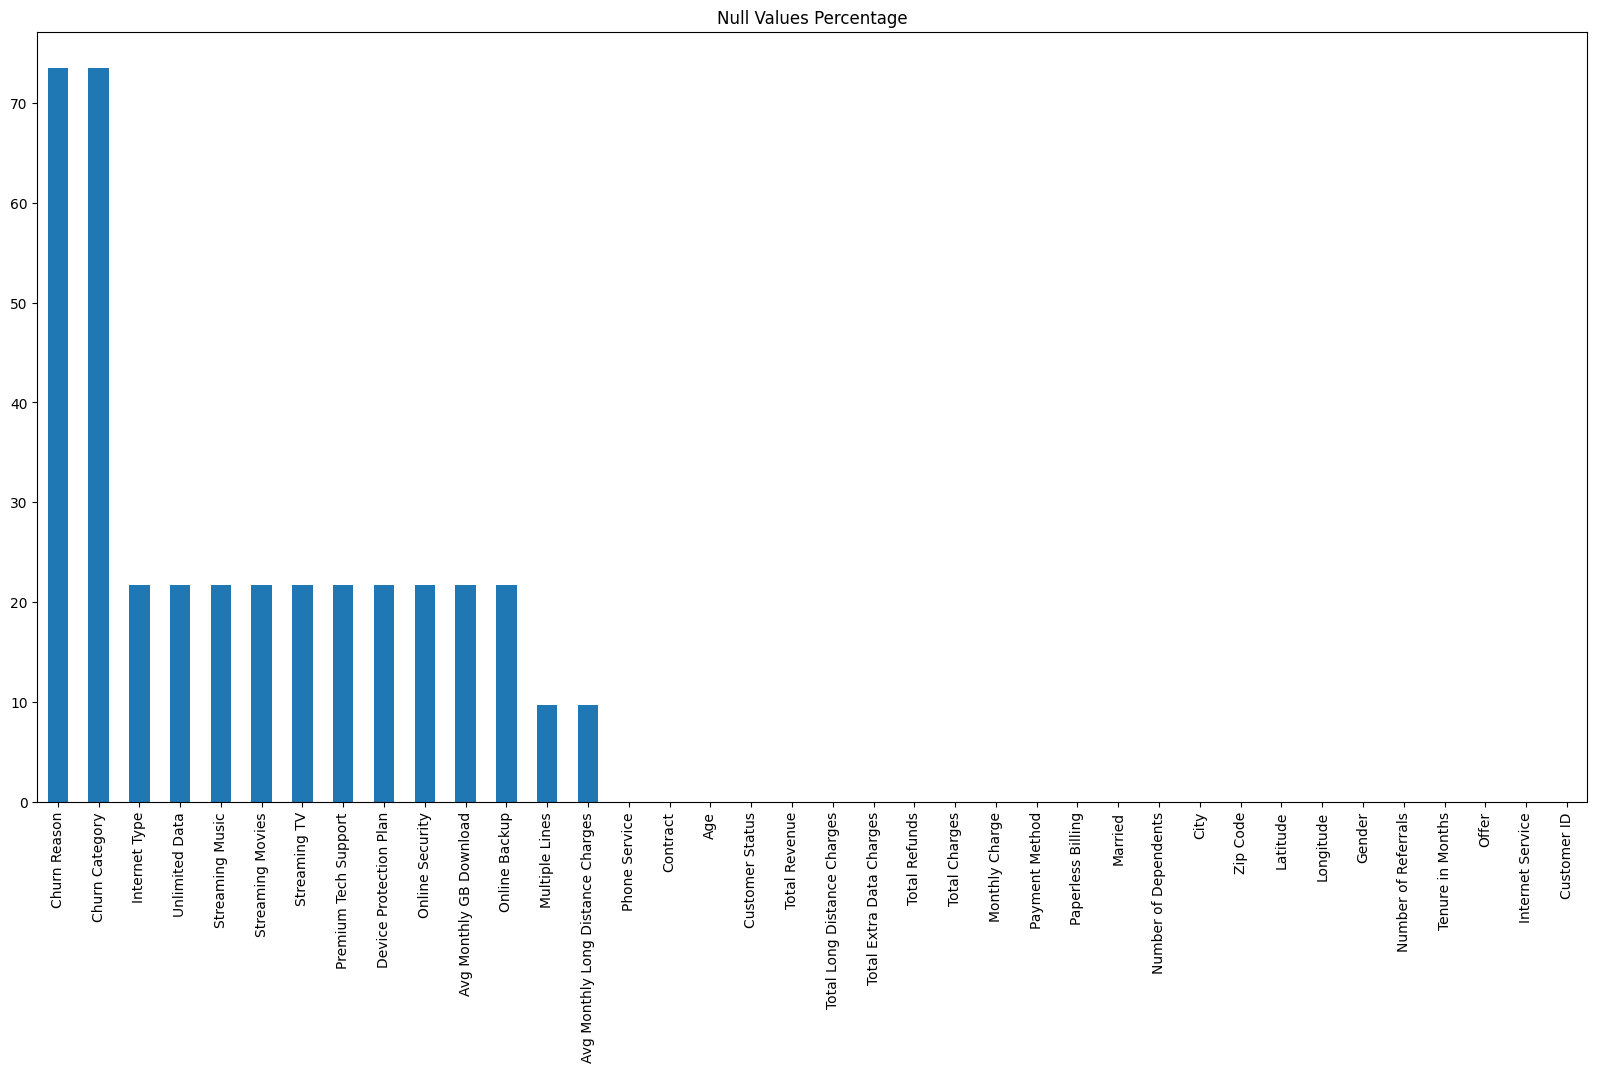

In [5]:
df=data.copy()
fig,ax = plt.subplots(figsize=(20,10))
(df.isna().sum()/df.shape[0]*100).sort_values(ascending=False).plot(kind='bar')
plt.title('Null Values Percentage')
plt.show()

In [6]:
# Filling missing values with specified values
data['Avg Monthly Long Distance Charges'].fillna(0, inplace=True)
data['Multiple Lines'].fillna('No', inplace=True)
data['Offer'].fillna('None', inplace=True)

# Rechecking for missing values in these columns
missing_values_updated = data[['Avg Monthly Long Distance Charges', 'Multiple Lines','Offer']].isnull().sum()
missing_values_updated

Avg Monthly Long Distance Charges    0
Multiple Lines                       0
Offer                                0
dtype: int64

In [7]:
data['Internet Type'].fillna('None', inplace=True)
data['Avg Monthly GB Download'].fillna(0, inplace=True)

# Columns to fill missing values with 'No' for those who don't have Internet
columns_to_fill = ['Online Security', 'Online Backup', 'Device Protection Plan',
                   'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
                   'Streaming Music', 'Unlimited Data']

# Filling missing values with 'No' for the specified columns
for col in columns_to_fill:
    data[col].fillna('No', inplace=True)

# Rechecking for missing values in these columns
missing_values_filled = data[columns_to_fill].isnull().sum()
missing_values_filled


Online Security           0
Online Backup             0
Device Protection Plan    0
Premium Tech Support      0
Streaming TV              0
Streaming Movies          0
Streaming Music           0
Unlimited Data            0
dtype: int64

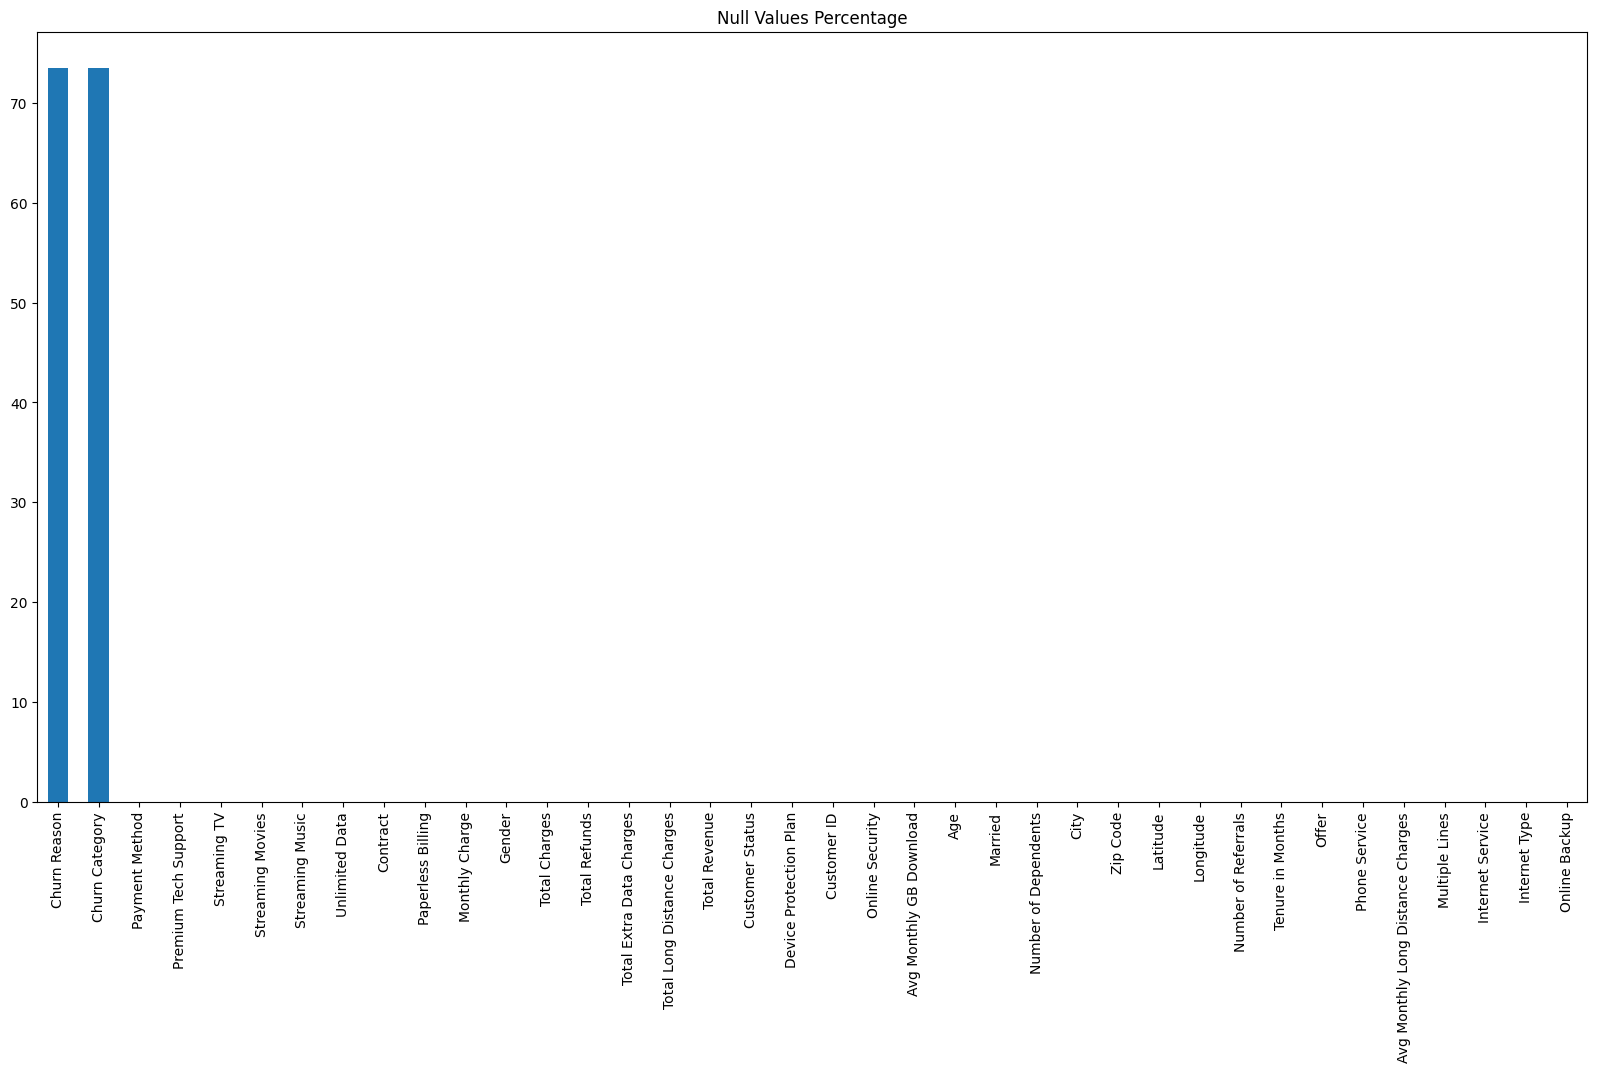

In [8]:
df=data.copy()
fig,ax = plt.subplots(figsize=(20,10))
(df.isna().sum()/df.shape[0]*100).sort_values(ascending=False).plot(kind='bar')
plt.title('Null Values Percentage')
plt.show()

In [9]:
# # Filtering out rows where 'Customer Status' is 'join', since we are only predicting whether a customer will stay or churn
data_no_join = data[data['Customer Status'] != 'join']
data_no_join = data[data['Customer Status'] != 'Joined']


new_shape = data_no_join.shape
new_shape

(6589, 38)

In [10]:
# Dropping the columns for customer id, city, zip code, latitude, and longitude
columns_to_drop = ['Customer ID','City', 'Zip Code', 'Latitude', 'Longitude', 'Churn Category', 'Churn Reason']
data_no_location = data_no_join.drop(columns=columns_to_drop)

### Outliers

In [11]:
numerical_columns_full = data_no_location.select_dtypes(include=['int64', 'float64']).columns


# Applying the adjusted IQR method to remove outliers from the full dataset
data_full_adjusted_outliers = data_no_location.copy()

excluded_columns = ['Number of Dependents', 'Number of Referrals', 'Total Refunds', 'Total Extra Data Charges']
iqr_multiplier_full = 2  # Using a multiplier of 2


for col in numerical_columns_full:
    if col not in excluded_columns:
        Q1 = data_full_adjusted_outliers[col].quantile(0.25)
        Q3 = data_full_adjusted_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier_full * IQR
        upper_bound = Q3 + iqr_multiplier_full * IQR

        # Filtering the data
        filter_condition = (data_full_adjusted_outliers[col] >= lower_bound) & (data_full_adjusted_outliers[col] <= upper_bound)
        data_full_adjusted_outliers = data_full_adjusted_outliers[filter_condition]

# Checking the number of rows, columns after removing outliers
new_shape_after_excluding_columns = data_full_adjusted_outliers.shape
new_shape_after_excluding_columns

(6434, 31)

In [12]:
# Randomly selecting 1500 rows
sample_data = data_full_adjusted_outliers.sample(n=1500, random_state=42)
sample_data['Customer Status'] = sample_data['Customer Status'].replace({'Stayed': 0, 'Churned': 1})

sample_data.shape

(1500, 31)

## 2. Exploratory Data Analysis

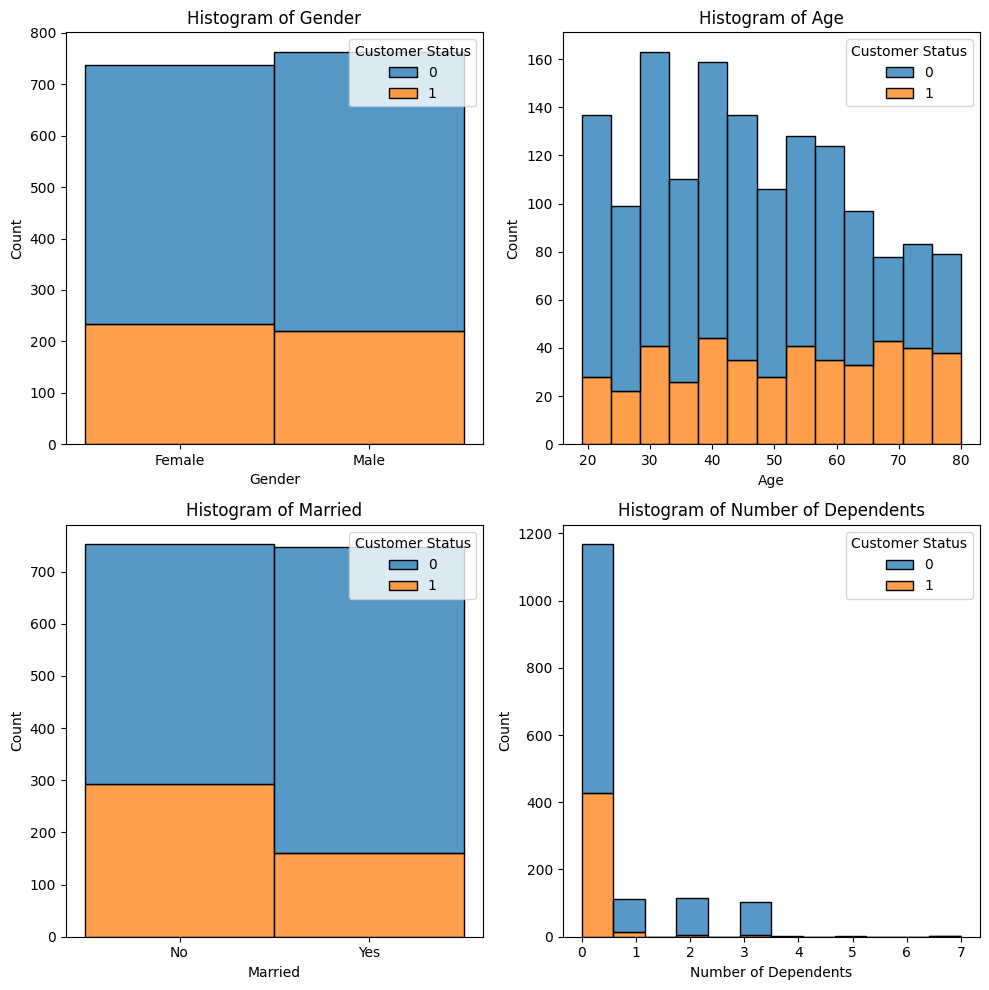

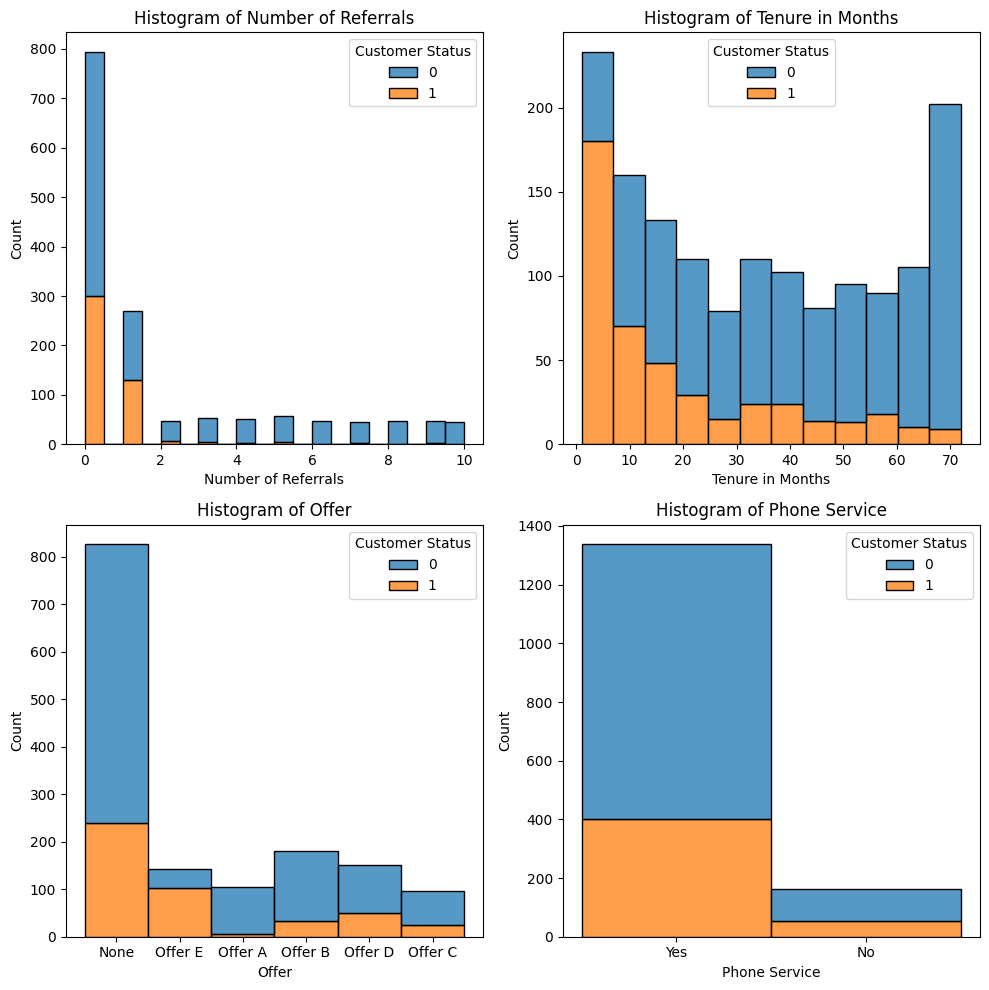

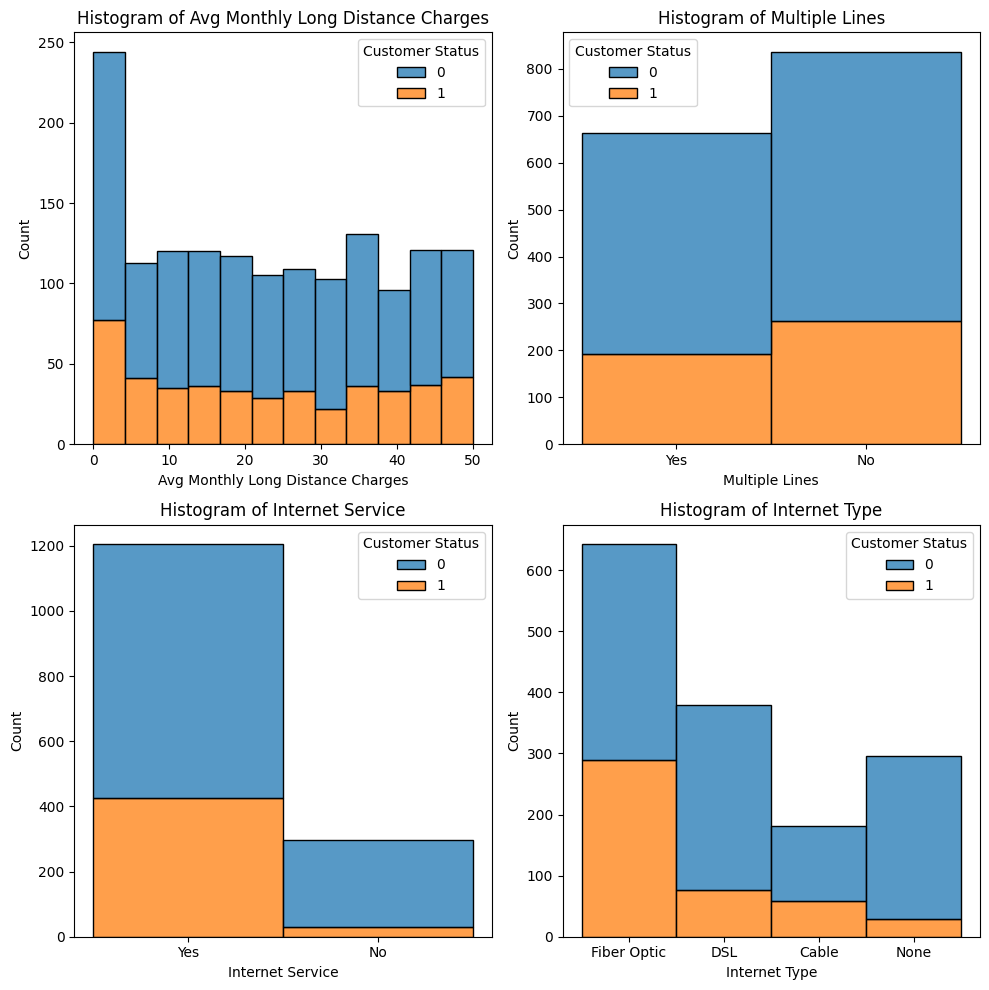

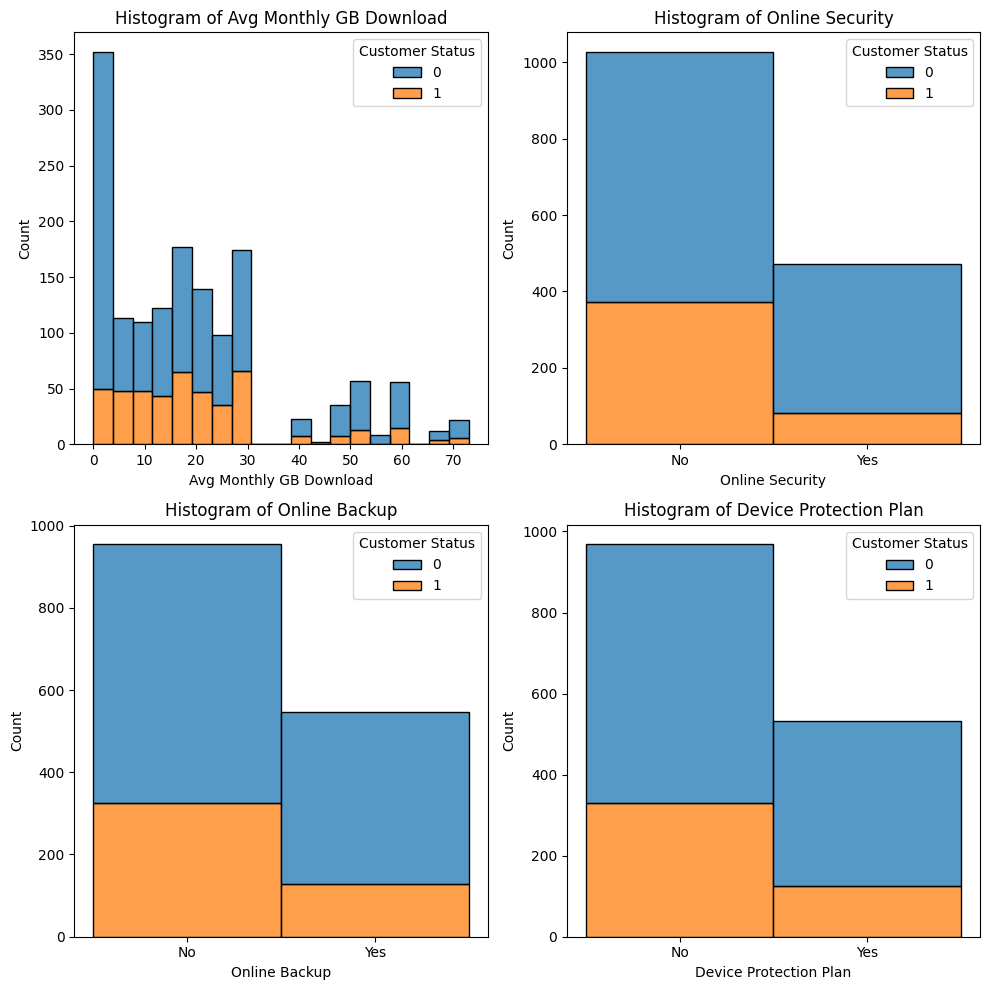

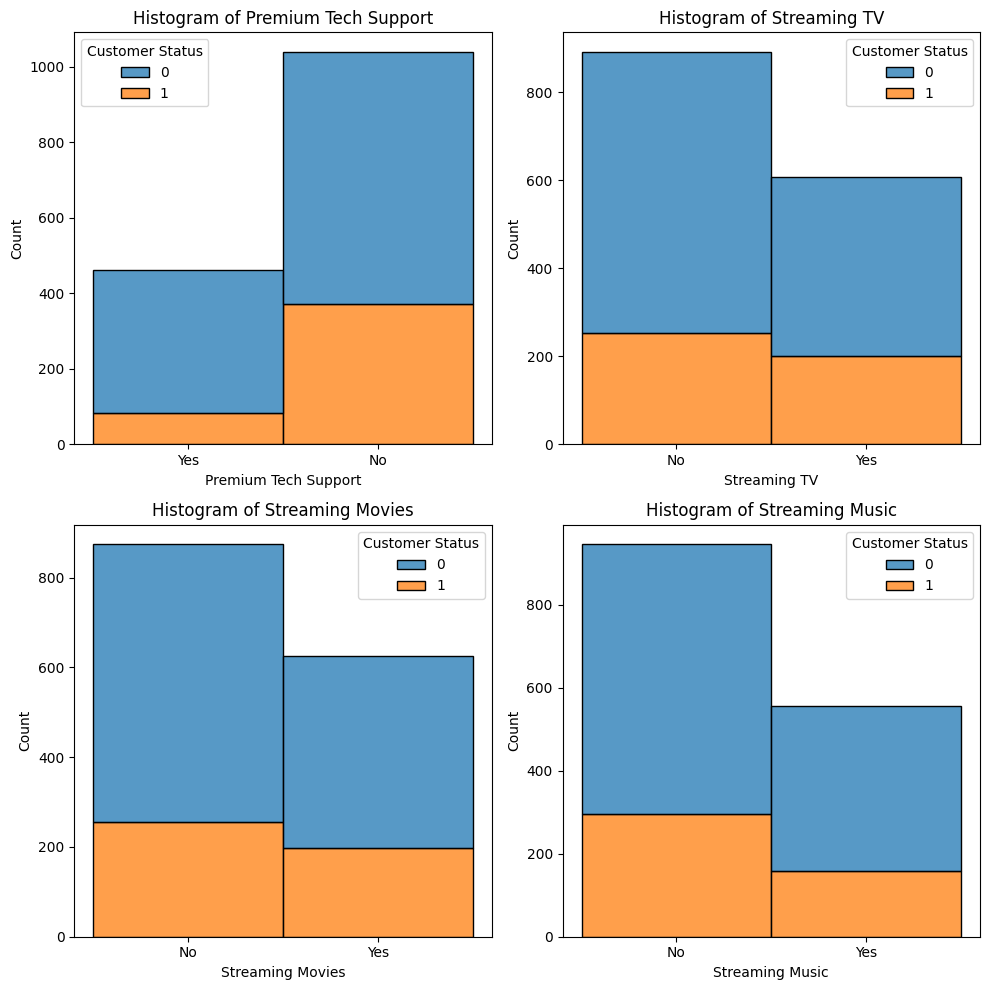

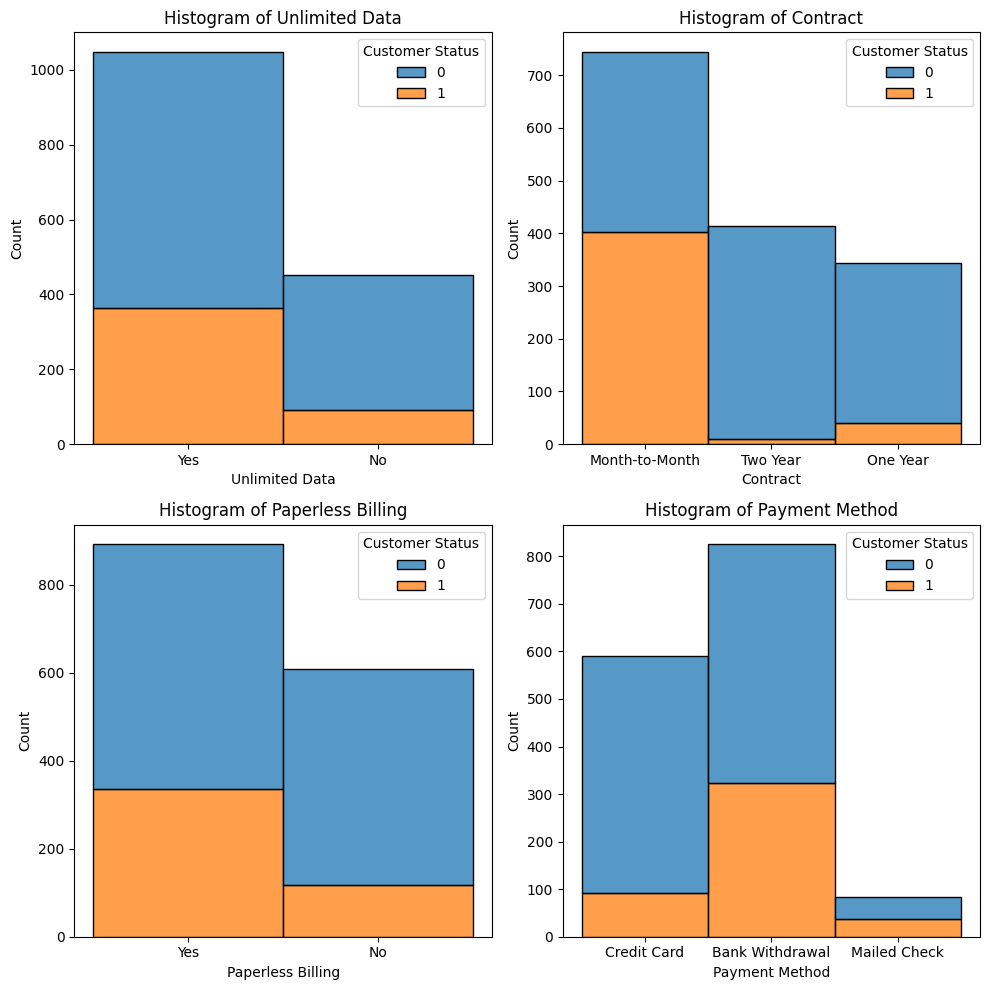

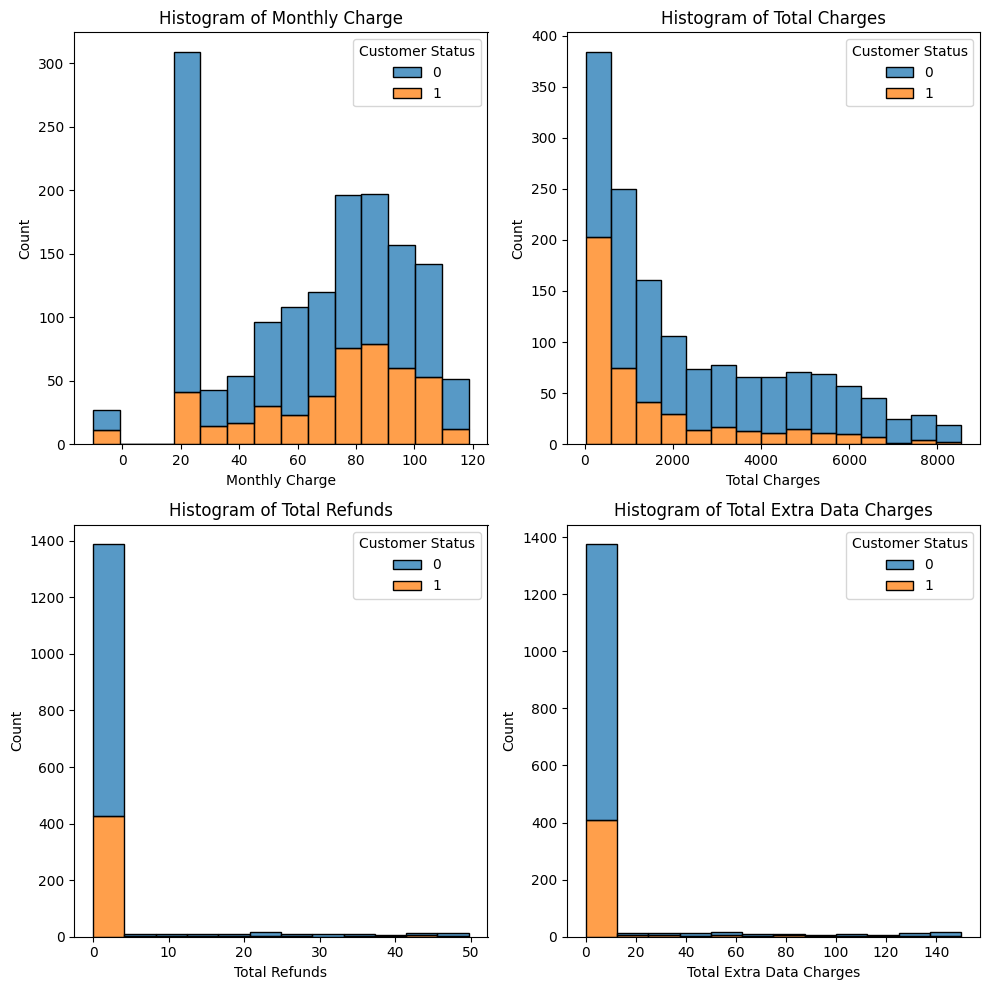

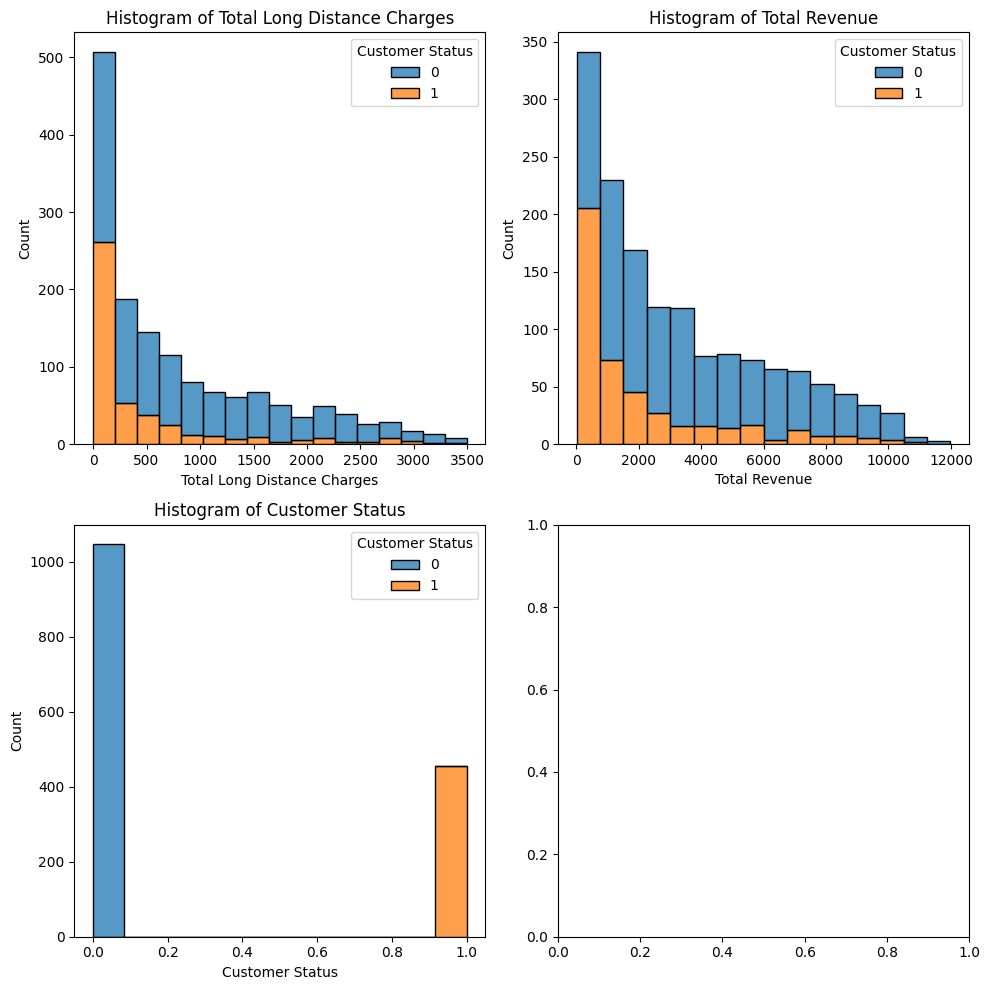

In [13]:
# Create a list of column names
columns = sample_data.columns.tolist()

for i in range(0, len(columns), 4):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, column in zip(axs.flatten(), columns[i:i+4]):
        sns.histplot(x=column, data=sample_data, hue='Customer Status', multiple="stack", ax=ax)
        ax.set_title(f'Histogram of {column}')
    plt.tight_layout()
    plt.show()


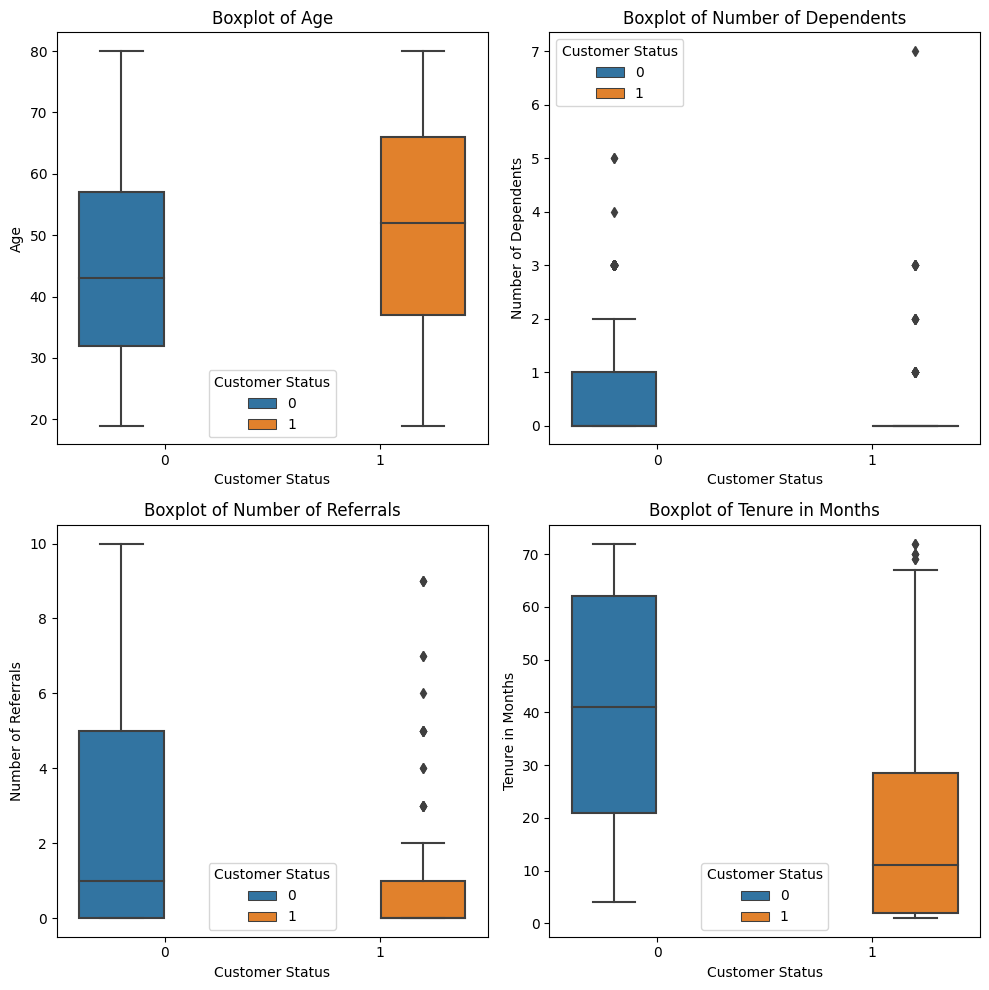

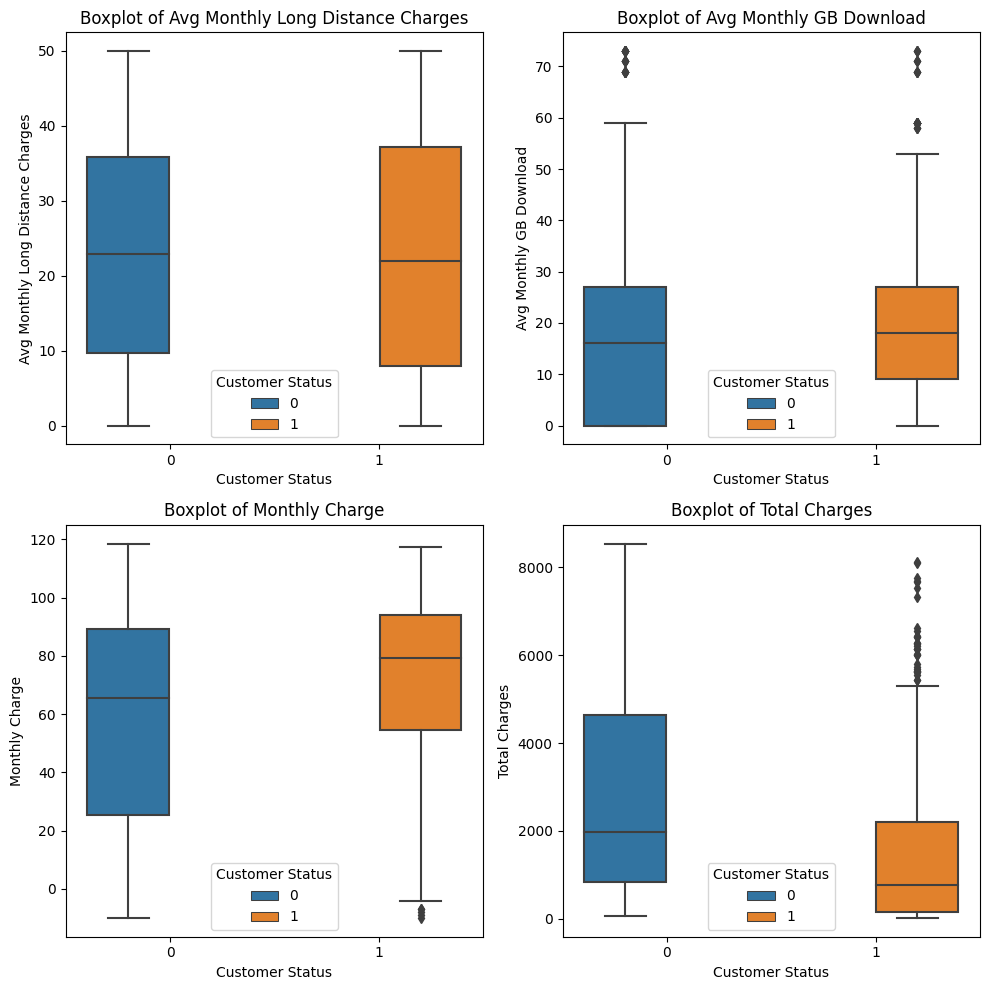

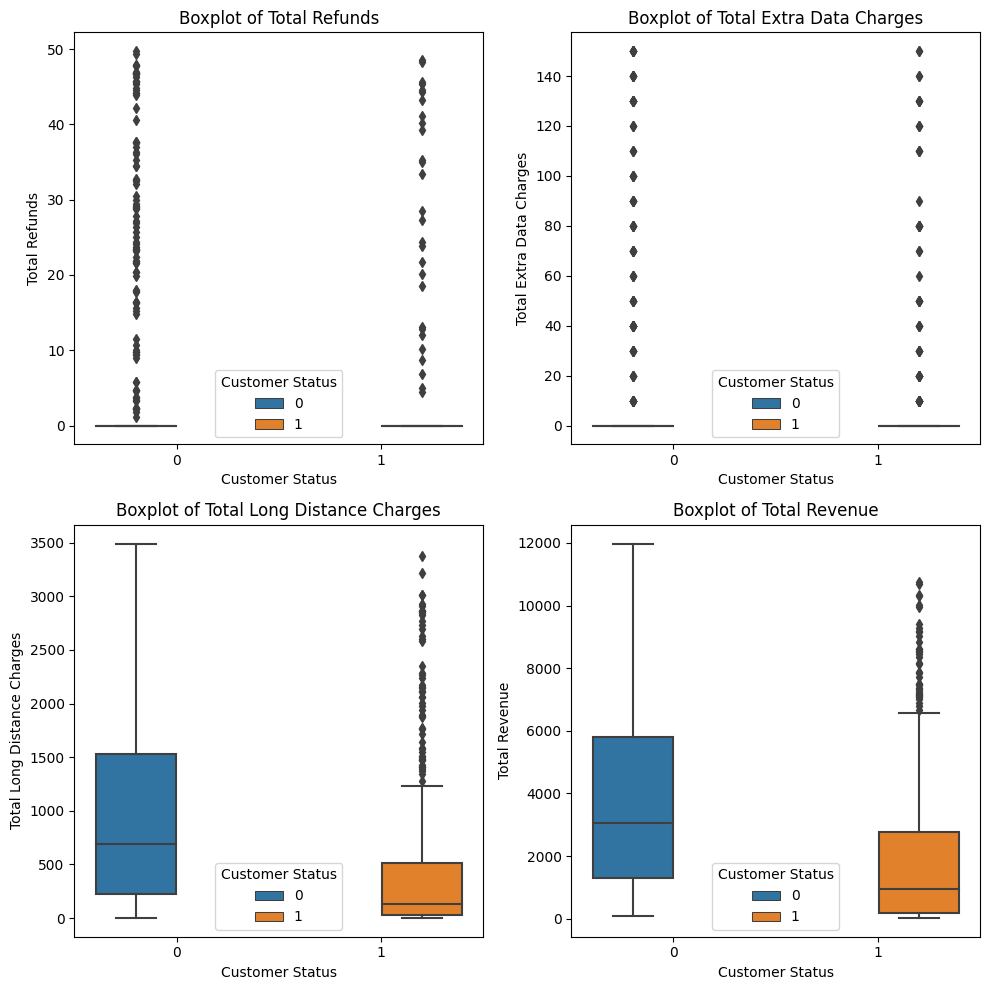

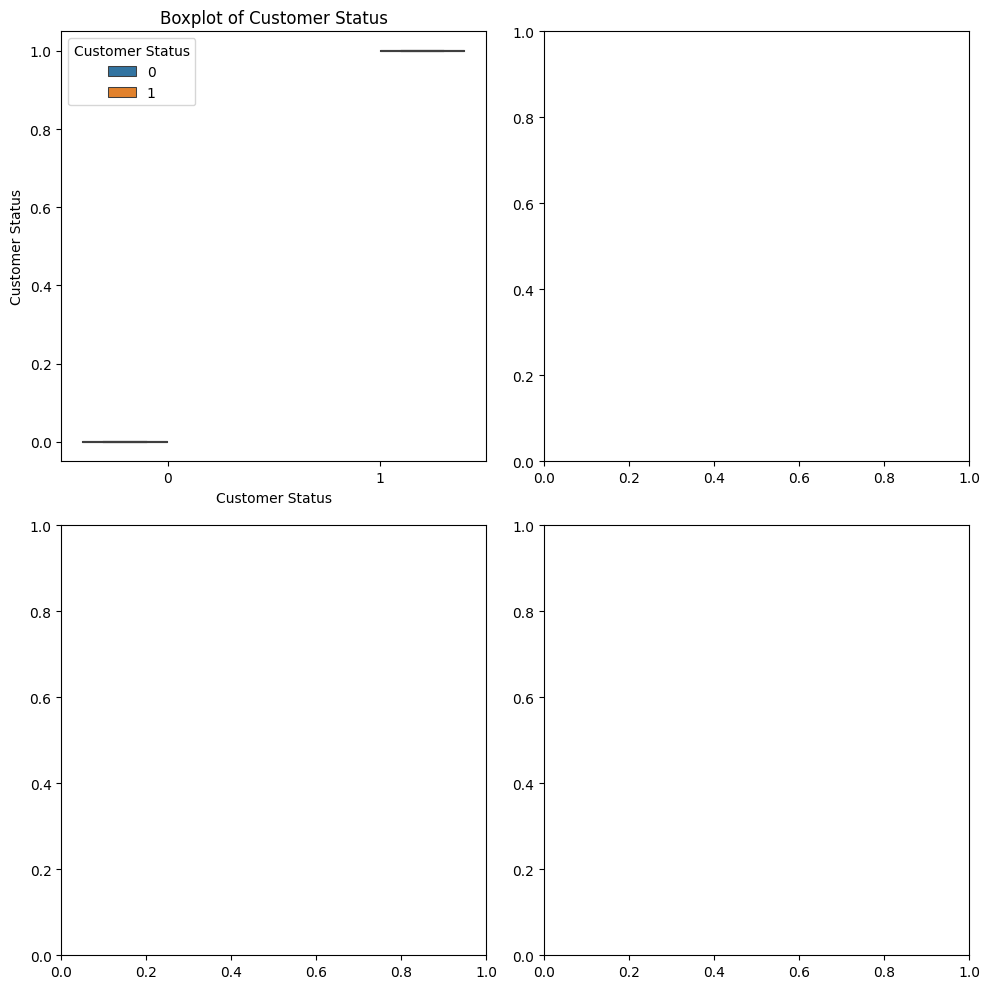

In [14]:
cols = list(sample_data.select_dtypes(include=['object']).columns)
df = sample_data.drop(cols, axis=1)
columns = df.columns.tolist()

for i in range(0, len(columns), 4):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, column in zip(axs.flatten(), columns[i:i+4]):
        sns.boxplot(y=column,x='Customer Status', data=df, hue='Customer Status', ax=ax)
        ax.set_title(f'Boxplot of {column}')
    plt.tight_layout()
    plt.show()


### Encode Categorical Variables

In [15]:
# Identifying categorical columns
categorical_columns = sample_data.select_dtypes(include=['object']).columns

# Preparing the OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ], remainder='passthrough')

# Fitting and transforming the sample data
sample_data_encoded = preprocessor.fit_transform(sample_data)

# Getting the new feature names after one-hot encoding
new_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
new_feature_names = list(new_feature_names) + [col for col in sample_data.columns if col not in categorical_columns]

# Converting the encoded data back to a DataFrame
sample_data_encoded_df = pd.DataFrame(sample_data_encoded, columns=new_feature_names)
pd.set_option('display.max_columns', None)

sample_data_encoded_df.head()


Gender_Male  Married_Yes  Offer_Offer A  Offer_Offer B  Offer_Offer C  \
0          0.0          0.0            0.0            0.0            0.0   
1          0.0          0.0            0.0            0.0            0.0   
2          0.0          0.0            1.0            0.0            0.0   
3          1.0          1.0            1.0            0.0            0.0   
4          0.0          0.0            0.0            1.0            0.0   

   Offer_Offer D  Offer_Offer E  Phone Service_Yes  Multiple Lines_Yes  \
0            0.0            0.0                1.0                 1.0   
1            0.0            1.0                1.0                 0.0   
2            0.0            0.0                1.0                 1.0   
3            0.0            0.0                1.0                 0.0   
4            0.0            0.0                0.0                 0.0   

   Internet Service_Yes  Internet Type_DSL  Internet Type_Fiber Optic  \
0                   1.0                0.0                        1.0   
1                   1.0                1.0                        0.0   
2                   1.0                1.0                        0.0   
3                   1.0                0.0                        0.0   
4                   1.0                1.0                        0.0   

   Internet Type_None  Online Security_Yes  Online Backup_Yes  \
0                 0.0                  0.0                0.0   
1                 0.0                  0.0                1.0   
2                 0.0                  1.0                0.0   
3                 0.0                  0.0                1.0   
4                 0.0                  0.0                1.0   

   Device Protection Plan_Yes  Premium Tech Support_Yes  Streaming TV_Yes  \
0                         0.0                       1.0               0.0   
1                         0.0                       1.0               0.0   
2                         1.0                       1.0               1.0   
3                         0.0                       1.0               1.0   
4                         1.0                       0.0               1.0   

   Streaming Movies_Yes  Streaming Music_Yes  Unlimited Data_Yes  \
0                   0.0                  0.0                 1.0   
1                   0.0                  0.0                 1.0   
2                   1.0                  1.0                 1.0   
3                   1.0                  1.0                 1.0   
4                   1.0                  1.0                 1.0   

   Contract_One Year  Contract_Two Year  Paperless Billing_Yes  \
0                0.0                0.0                    1.0   
1                0.0                0.0                    1.0   
2                0.0                1.0                    1.0   
3                0.0                1.0                    1.0   
4                0.0                1.0                    1.0   

   Payment Method_Credit Card  Payment Method_Mailed Check   Age  \
0                         1.0                          0.0  58.0   
1                         1.0                          0.0  47.0   
2                         1.0                          0.0  42.0   
3                         1.0                          0.0  30.0   
4                         0.0                          0.0  65.0   

   Number of Dependents  Number of Referrals  Tenure in Months  \
0                   0.0                  0.0              31.0   
1                   0.0                  0.0               2.0   
2                   0.0                  0.0              69.0   
3                   0.0                  4.0              71.0   
4                   0.0                  0.0              57.0   

   Avg Monthly Long Distance Charges  Avg Monthly GB Download  Monthly Charge  \
0                              16.63                     12.0           79.85   
1                              42.

### Scale Numerical variables

In [16]:
# Identifying numerical columns (excluding the target variable 'Customer Status')
numerical_columns = sample_data.select_dtypes(include=['int64', 'float64']).columns.drop('Customer Status')

# StandardScaler for scaling numerical variables
scaler = StandardScaler()

# Scaling the numerical variables
sample_data_encoded_df[numerical_columns] = scaler.fit_transform(sample_data[numerical_columns])

sample_data_encoded_df.head()

Gender_Male  Married_Yes  Offer_Offer A  Offer_Offer B  Offer_Offer C  \
0          0.0          0.0            0.0            0.0            0.0   
1          0.0          0.0            0.0            0.0            0.0   
2          0.0          0.0            1.0            0.0            0.0   
3          1.0          1.0            1.0            0.0            0.0   
4          0.0          0.0            0.0            1.0            0.0   

   Offer_Offer D  Offer_Offer E  Phone Service_Yes  Multiple Lines_Yes  \
0            0.0            0.0                1.0                 1.0   
1            0.0            1.0                1.0                 0.0   
2            0.0            0.0                1.0                 1.0   
3            0.0            0.0                1.0                 0.0   
4            0.0            0.0                0.0                 0.0   

   Internet Service_Yes  Internet Type_DSL  Internet Type_Fiber Optic  \
0                   1.0                0.0                        1.0   
1                   1.0                1.0                        0.0   
2                   1.0                1.0                        0.0   
3                   1.0                0.0                        0.0   
4                   1.0                1.0                        0.0   

   Internet Type_None  Online Security_Yes  Online Backup_Yes  \
0                 0.0                  0.0                0.0   
1                 0.0                  0.0                1.0   
2                 0.0                  1.0                0.0   
3                 0.0                  0.0                1.0   
4                 0.0                  0.0                1.0   

   Device Protection Plan_Yes  Premium Tech Support_Yes  Streaming TV_Yes  \
0                         0.0                       1.0               0.0   
1                         0.0                       1.0               0.0   
2                         1.0                       1.0               1.0   
3                         0.0                       1.0               1.0   
4                         1.0                       0.0               1.0   

   Streaming Movies_Yes  Streaming Music_Yes  Unlimited Data_Yes  \
0                   0.0                  0.0                 1.0   
1                   0.0                  0.0                 1.0   
2                   1.0                  1.0                 1.0   
3                   1.0                  1.0                 1.0   
4                   1.0                  1.0                 1.0   

   Contract_One Year  Contract_Two Year  Paperless Billing_Yes  \
0                0.0                0.0                    1.0   
1                0.0                0.0                    1.0   
2                0.0                1.0                    1.0   
3                0.0                1.0                    1.0   
4                0.0                1.0                    1.0   

   Payment Method_Credit Card  Payment Method_Mailed Check       Age  \
0                         1.0                          0.0  0.674089   
1                         1.0                          0.0  0.016383   
2                         1.0                          0.0 -0.282574   
3                         1.0                          0.0 -1.000072   
4                         0.0                          0.0  1.092629   

   Number of Dependents  Number of Referrals  Tenure in Months  \
0             -0.477828            -0.645724         -0.128731   
1             -0.477828            -0.645724         -1.352465   
2             -0.477828            -0.645724          1.474782   
3             -0.477828             0.721852          1.559178   
4             -0.477828            -0.645724          0.968410   

   Avg Monthly Long Distance Charges  Avg Monthly GB Download  Monthly Charge  \
0                          -0.398164                -0.405619        0.480428   
1         

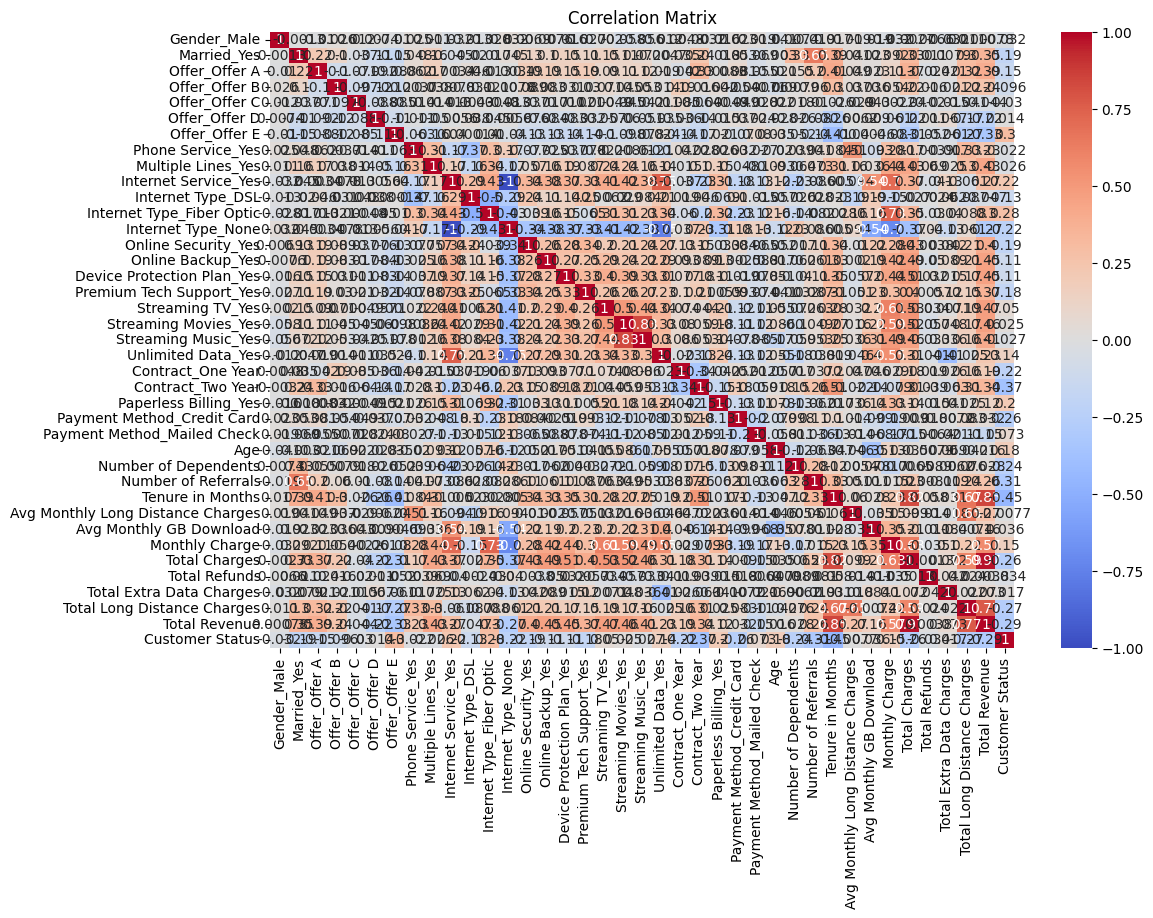

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


feature        VIF
0                         Gender_Male   1.016237
1                         Married_Yes   2.033756
2                       Offer_Offer A   1.393786
3                       Offer_Offer B   1.273029
4                       Offer_Offer C   1.085974
5                       Offer_Offer D   1.187615
6                       Offer_Offer E   1.353305
7                   Phone Service_Yes   2.233587
8                  Multiple Lines_Yes   1.514008
9                Internet Service_Yes  62.569558
10                  Internet Type_DSL   2.385327
11          Internet Type_Fiber Optic   4.835188
12                 Internet Type_None  18.334054
13                Online Security_Yes   1.587076
14                  Online Backup_Yes   1.553148
15         Device Protection Plan_Yes   1.596247
16           Premium Tech Support_Yes   1.599662
17                   Streaming TV_Yes   2.047351
18               Streaming Movies_Yes   4.874865
19                Streaming Music_Yes   4.261304
20                 Unlimited Data_Yes   6.366012
21                  Contract_One Year   1.778808
22                  Contract_Two Year   2.599480
23              Paperless Billing_Yes   1.219474
24         Payment Method_Credit Card   1.234493
25        Payment Method_Mailed Check   1.140997
26                                Age   1.692528
27               Number of Dependents   1.310725
28                Number of Referrals   1.885556
29                   Tenure in Months   9.755316
30  Avg Monthly Long Distance Charges   3.786101
31            Avg Monthly GB Download   2.003158
32                     Monthly Charge  10.340883
33                      Total Charges        inf
34                      Total Refunds        inf
35           Total Extra Data Charges        inf
36        Total Long Distance Charges        inf
37                      Total Revenue        inf
38                    Customer Status   1.759383

In [17]:
# Assuming 'df' is your DataFrame
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Filter only numeric columns for VIF calculation
numeric_data = sample_data_encoded_df.select_dtypes(include=[np.number])

# Creating and visualizing the correlation matrix
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Calculating VIF
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_data.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(len(numeric_data.columns))]

vif_data

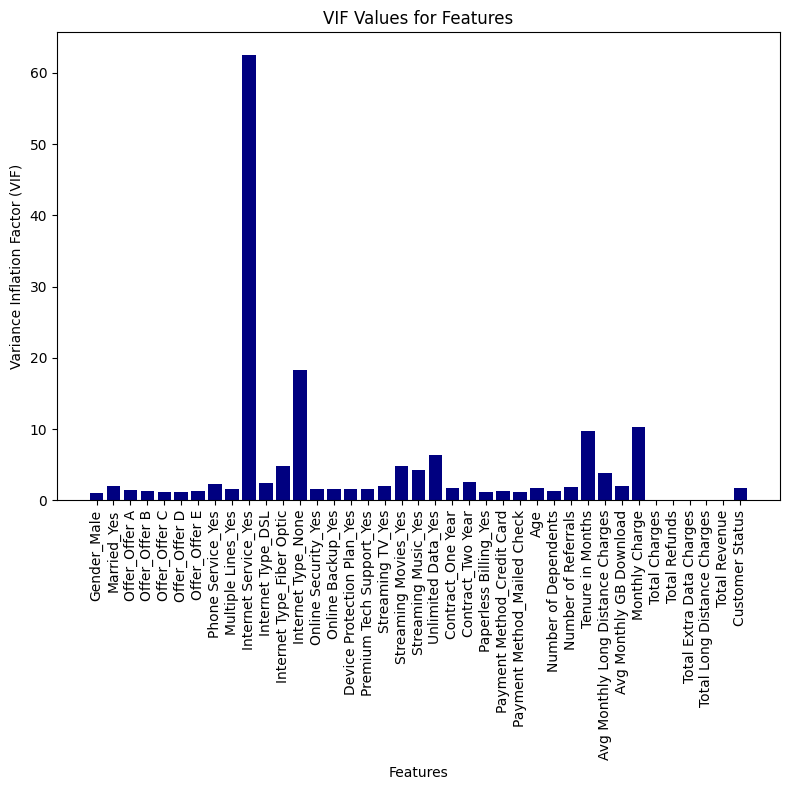

In [18]:
plt.figure(figsize=(8, 8))
plt.bar(vif_data['feature'], vif_data['VIF'], color='navy')
plt.ylabel('Variance Inflation Factor (VIF)')
plt.xlabel('Features')
plt.title('VIF Values for Features')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

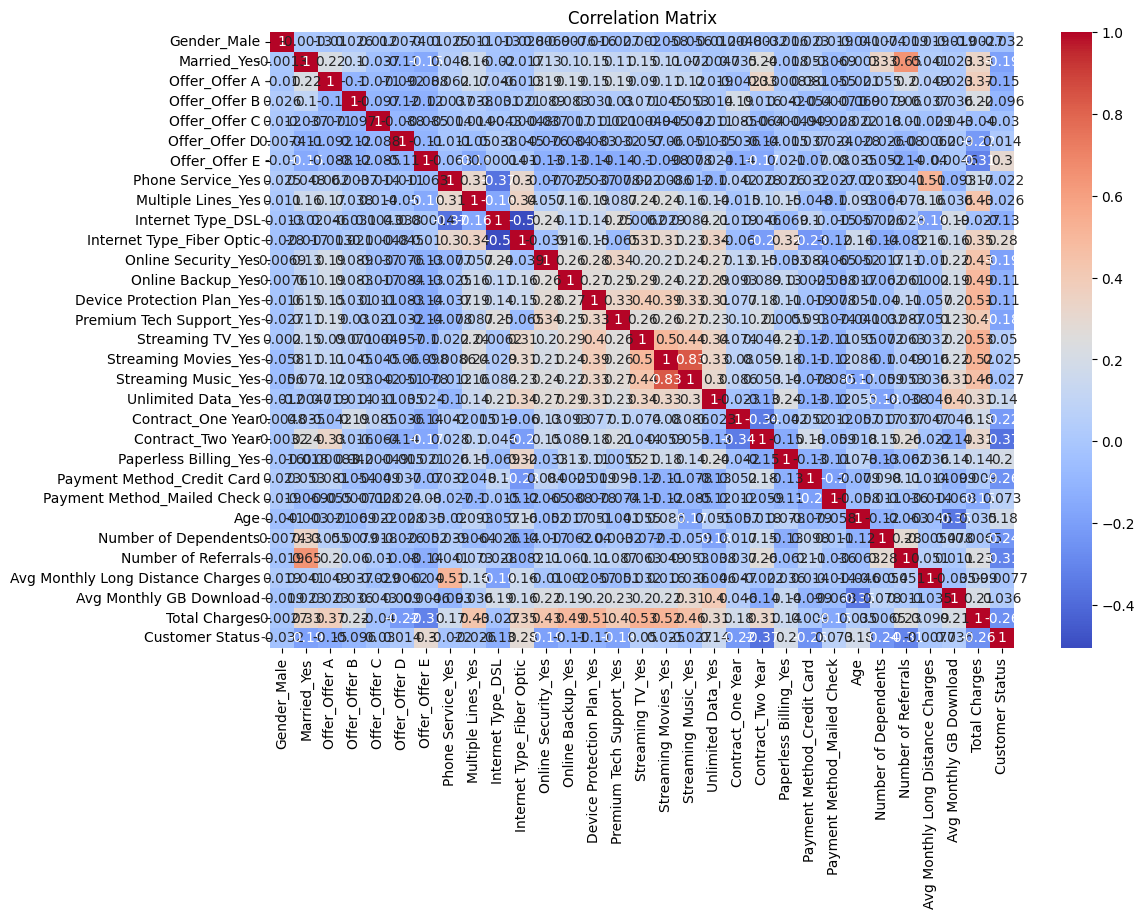

feature       VIF
0                         Gender_Male  2.002296
1                         Married_Yes  3.734256
2                       Offer_Offer A  1.446733
3                       Offer_Offer B  1.336831
4                       Offer_Offer C  1.148130
5                       Offer_Offer D  1.289007
6                       Offer_Offer E  1.401851
7                   Phone Service_Yes  9.403391
8                  Multiple Lines_Yes  2.564939
9                   Internet Type_DSL  2.498992
10          Internet Type_Fiber Optic  4.907016
11                Online Security_Yes  2.071715
12                  Online Backup_Yes  2.144307
13         Device Protection Plan_Yes  2.351986
14           Premium Tech Support_Yes  2.051482
15                   Streaming TV_Yes  2.829898
16               Streaming Movies_Yes  7.632472
17                Streaming Music_Yes  6.710775
18                 Unlimited Data_Yes  5.681990
19                  Contract_One Year  1.980305
20                  Contract_Two Year  2.675519
21              Paperless Billing_Yes  2.869816
22         Payment Method_Credit Card  1.954406
23        Payment Method_Mailed Check  1.166363
24                                Age  1.568909
25               Number of Dependents  1.286517
26                Number of Referrals  1.844754
27  Avg Monthly Long Distance Charges  1.263684
28            Avg Monthly GB Download  1.653346
29                      Total Charges  3.656092
30                    Customer Status  2.454477

In [19]:
# Remove the features with high VIF values
columns_to_remove = ['Monthly Charge', 'Tenure in Months', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue', 'Internet Service_Yes', 'Internet Type_None']
sample_data_reduced = sample_data_encoded_df.drop(columns=columns_to_remove)

numeric_data_reduced = sample_data_reduced.select_dtypes(include=[np.number])

# Creating and visualizing the correlation matrix
correlation_matrix = numeric_data_reduced.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Re-calculate the VIF for the remaining features
numeric_data_reduced = sample_data_reduced.select_dtypes(include=[np.number])
vif_data_reduced = pd.DataFrame()
vif_data_reduced["feature"] = numeric_data_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(numeric_data_reduced.values, i) for i in range(len(numeric_data_reduced.columns))]

vif_data_reduced


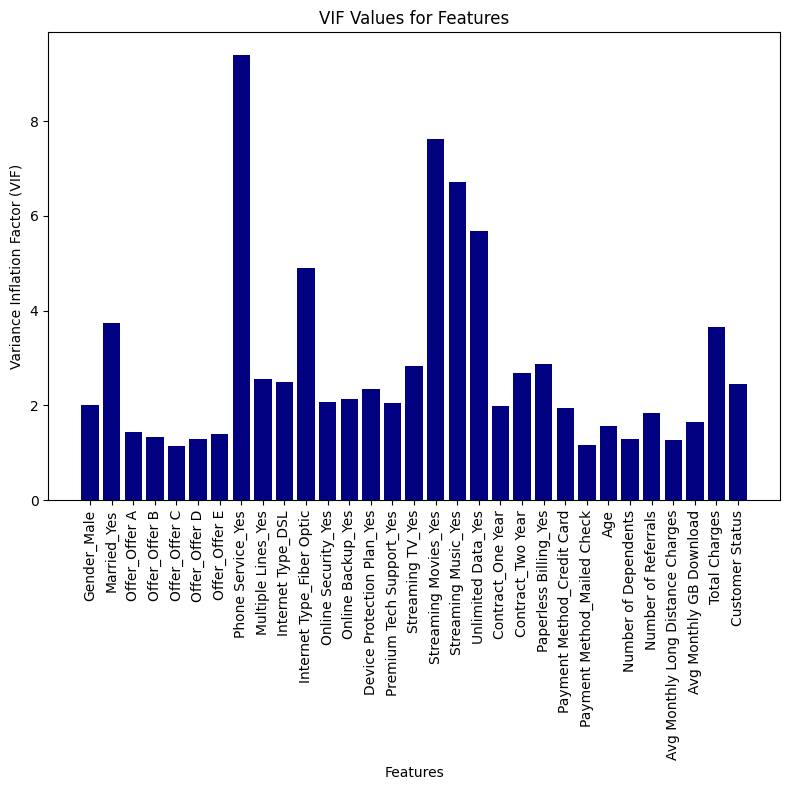

In [20]:
plt.figure(figsize=(8, 8))
plt.bar(vif_data_reduced['feature'], vif_data_reduced['VIF'], color='navy')
plt.ylabel('Variance Inflation Factor (VIF)')
plt.xlabel('Features')
plt.title('VIF Values for Features')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

Correlation and Multilinearity Issue Handled

### Full Model

In [21]:
# Splitting the dataset into features (X) and the target variable (y)
X = sample_data_reduced.drop('Customer Status', axis=1)
y = sample_data_reduced['Customer Status']


# Splitting into training and temp (which will be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# Splitting the temp data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(900, 30) (900,) (300, 30) (300,) (300, 30) (300,)


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Add a constant to the training set for the intercept
X_train_sm = sm.add_constant(X_train)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Print the summary of the regression
print(result.summary())

# Predict on the training set
y_train_pred_sm = result.predict(X_train_sm)

# Convert probabilities to binary predictions
y_train_pred_binary = [1 if x > 0.5 else 0 for x in y_train_pred_sm]

# Evaluate the model
accuracy = accuracy_score(y_train, y_train_pred_binary)
precision = precision_score(y_train, y_train_pred_binary)
recall = recall_score(y_train, y_train_pred_binary)
f1 = f1_score(y_train, y_train_pred_binary)
roc_auc = roc_auc_score(y_train, y_train_pred_sm)

print(f"\nAccuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

Optimization terminated successfully.
         Current function value: 0.331445
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:        Customer Status   No. Observations:                  900
Model:                          Logit   Df Residuals:                      869
Method:                           MLE   Df Model:                           30
Date:                Wed, 03 Jan 2024   Pseudo R-squ.:                  0.4591
Time:                        08:55:29   Log-Likelihood:                -298.30
converged:                       True   LL-Null:                       -551.46
Covariance Type:            nonrobust   LLR p-value:                 6.098e-88
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -1.5736      0.584     -2

## 3. Variable Selection

### Scenario 1: Use Lasso Regularization and choose 15 predictors

In [23]:
from sklearn.linear_model import LogisticRegressionCV

# Creating a logistic regression model with Lasso regularization
# The 'Cs' parameter represents the inverse of regularization strength; smaller values specify stronger regularization.
# 'cv' represents the number of cross-validation folds.
lasso_log_reg = LogisticRegressionCV(Cs=10, cv=5, penalty='l1', solver='liblinear', random_state=42, max_iter=1000)

# Fitting the model on the training data
lasso_log_reg.fit(X_train, y_train)

# Best regularization parameter
best_alpha = 1 / lasso_log_reg.C_[0]

best_alpha

# Creating and training the logistic regression model with Lasso regularization and the optimal alpha
lasso_log_reg_optimized = LogisticRegression(penalty='l1', C=1/best_alpha, solver='liblinear', random_state=42, max_iter=1000)
lasso_log_reg_optimized.fit(X_train, y_train)

# Extracting the coefficients
coefficients = lasso_log_reg_optimized.coef_[0]

# Creating a DataFrame for better visualization of the coefficients
features_coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})

# Identifying non-zero coefficients (features used in the model)
non_zero_features = features_coefficients[features_coefficients['Coefficient'] != 0]

non_zero_features

Feature  Coefficient
0                         Gender_Male    -0.004998
1                         Married_Yes     0.303740
4                       Offer_Offer C    -0.240627
5                       Offer_Offer D    -0.327839
6                       Offer_Offer E     0.970290
7                   Phone Service_Yes    -0.236950
9                   Internet Type_DSL    -0.279559
10          Internet Type_Fiber Optic     0.731178
11                Online Security_Yes    -0.315313
15                   Streaming TV_Yes     0.359674
16               Streaming Movies_Yes     0.278684
19                  Contract_One Year    -1.400671
20                  Contract_Two Year    -2.493032
21              Paperless Billing_Yes     0.394040
22         Payment Method_Credit Card    -0.822679
24                                Age     0.384301
25               Number of Dependents    -0.504016
26                Number of Referrals    -0.837963
27  Avg Monthly Long Distance Charges     0.067116
28            Avg Monthly GB Download     0.156237
29                      Total Charges    -0.419762

In [24]:
# Sorting the features based on the absolute value of their coefficients
# Correcting the error by applying the abs() function only to the 'Coefficient' column
top_n_features = non_zero_features.assign(Abs_Coefficient=non_zero_features['Coefficient'].abs())
top_n_features_sorted = top_n_features.sort_values(by='Abs_Coefficient', ascending=False).head(15)

top_n_features_sorted[['Feature', 'Coefficient']]

Feature  Coefficient
20           Contract_Two Year    -2.493032
19           Contract_One Year    -1.400671
6                Offer_Offer E     0.970290
26         Number of Referrals    -0.837963
22  Payment Method_Credit Card    -0.822679
10   Internet Type_Fiber Optic     0.731178
25        Number of Dependents    -0.504016
29               Total Charges    -0.419762
21       Paperless Billing_Yes     0.394040
24                         Age     0.384301
15            Streaming TV_Yes     0.359674
5                Offer_Offer D    -0.327839
11         Online Security_Yes    -0.315313
1                  Married_Yes     0.303740
9            Internet Type_DSL    -0.279559

### Checking Statistical Significance

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
# Select only the features identified by Lasso regularization
selected_features = top_n_features_sorted['Feature']  # Adjust this if necessary
X_train_selected = X_train[selected_features]

# Add a constant to the predictor variable set to represent the intercept
X_train_selected_with_const = sm.add_constant(X_train_selected)
X_test_selected_with_const = sm.add_constant(X_test[selected_features], has_constant='add')


# Fit the logistic regression model
model = sm.Logit(y_train, X_train_selected_with_const)
result = model.fit()

# Print the summary to get the p-values
print(result.summary2())# Fit the logistic regression model

Optimization terminated successfully.
         Current function value: 0.340377
         Iterations 8
                              Results: Logit
Model:                 Logit               Method:              MLE       
Dependent Variable:    Customer Status     Pseudo R-squared:    0.444     
Date:                  2024-01-03 08:55    AIC:                 644.6780  
No. Observations:      900                 BIC:                 721.5163  
Df Model:              15                  Log-Likelihood:      -306.34   
Df Residuals:          884                 LL-Null:             -551.46   
Converged:             1.0000              LLR p-value:         6.5308e-95
No. Iterations:        8.0000              Scale:               1.0000    
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
const                      -

In [26]:
# Obtain the summary
summary = result.summary2().tables[1]

# Extract p-values and filter features
significant_features = summary[summary['P>|z|'] < 0.05]['Coef.']

# Print the significant features
print(significant_features)

const                        -1.748473
Contract_Two Year            -2.917235
Contract_One Year            -1.574890
Offer_Offer E                 1.316542
Number of Referrals          -1.155427
Payment Method_Credit Card   -0.911629
Internet Type_Fiber Optic     0.964142
Number of Dependents         -0.645872
Total Charges                -0.543125
Paperless Billing_Yes         0.594257
Age                           0.327423
Streaming TV_Yes              0.718335
Married_Yes                   0.784755
Name: Coef., dtype: float64


### Model Fitting


In [27]:
from sklearn.metrics import roc_auc_score, recall_score

# Select only the features identified by Lasso regularization
significant_predictors = significant_features.index.tolist()
significant_predictors = [predictor for predictor in significant_predictors if predictor != 'const']



# Now select the data from X_train and X_test
X_train_sig = X_train[significant_predictors]
X_test_sig = X_test[significant_predictors]



# Re-train the model with the updated list of significant predictors
X_train_sig_with_const = sm.add_constant(X_train_sig)
X_test_sig_with_const = sm.add_constant(X_test_sig)

model = sm.Logit(y_train, X_train_sig_with_const)
result_lasso = model.fit()
print(result_lasso.summary2())


# Make predictions on the test data
predictions_prob_lasso = result_lasso.predict(X_test_sig_with_const)
predictions_lasso = np.where(predictions_prob_lasso > 0.5, 1, 0)  # Convert probabilities to 0/1

# Calculate accuracy
accuracy_lasso = np.mean(predictions_lasso == y_test)

# Calculate Recall
recall_lasso = recall_score(y_test, predictions_lasso)

# Calculate AUC-ROC
auc_roc_lasso = roc_auc_score(y_test, predictions_prob_lasso)

print(f"Recall: {recall_lasso:.2f}")
print(f"AUC-ROC: {auc_roc_lasso:.2f}")

print(f"Accuracy: {accuracy_lasso:.2f}")

Optimization terminated successfully.
         Current function value: 0.344021
         Iterations 8
                              Results: Logit
Model:                 Logit               Method:              MLE       
Dependent Variable:    Customer Status     Pseudo R-squared:    0.439     
Date:                  2024-01-03 08:55    AIC:                 645.2370  
No. Observations:      900                 BIC:                 707.6682  
Df Model:              12                  Log-Likelihood:      -309.62   
Df Residuals:          887                 LL-Null:             -551.46   
Converged:             1.0000              LLR p-value:         6.5505e-96
No. Iterations:        8.0000              Scale:               1.0000    
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
const                      -

In [28]:
# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_train_sig_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_train_sig_with_const.values, i) for i in range(X_train_sig_with_const.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

Feature        VIF
0                        const  10.156995
8                Total Charges   2.308418
12                 Married_Yes   1.900026
4          Number of Referrals   1.749104
1            Contract_Two Year   1.746848
6    Internet Type_Fiber Optic   1.646618
11            Streaming TV_Yes   1.475592
2            Contract_One Year   1.400278
7         Number of Dependents   1.228978
9        Paperless Billing_Yes   1.195607
3                Offer_Offer E   1.142933
5   Payment Method_Credit Card   1.104673
10                         Age   1.098033

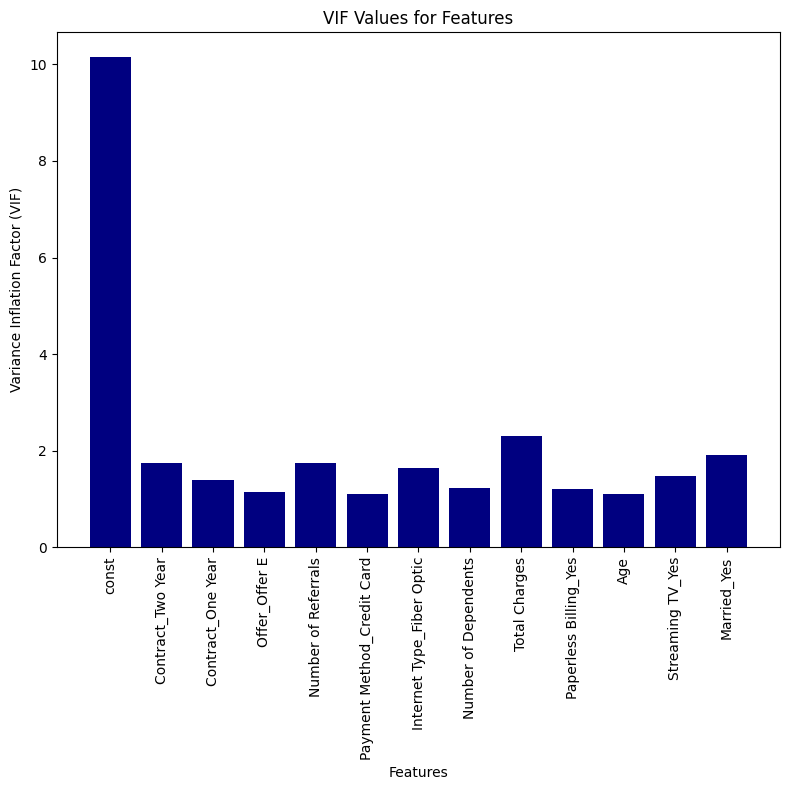

In [29]:
plt.figure(figsize=(8, 8))
plt.bar(vif_data['Feature'], vif_data['VIF'], color='navy')
plt.ylabel('Variance Inflation Factor (VIF)')
plt.xlabel('Features')
plt.title('VIF Values for Features')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

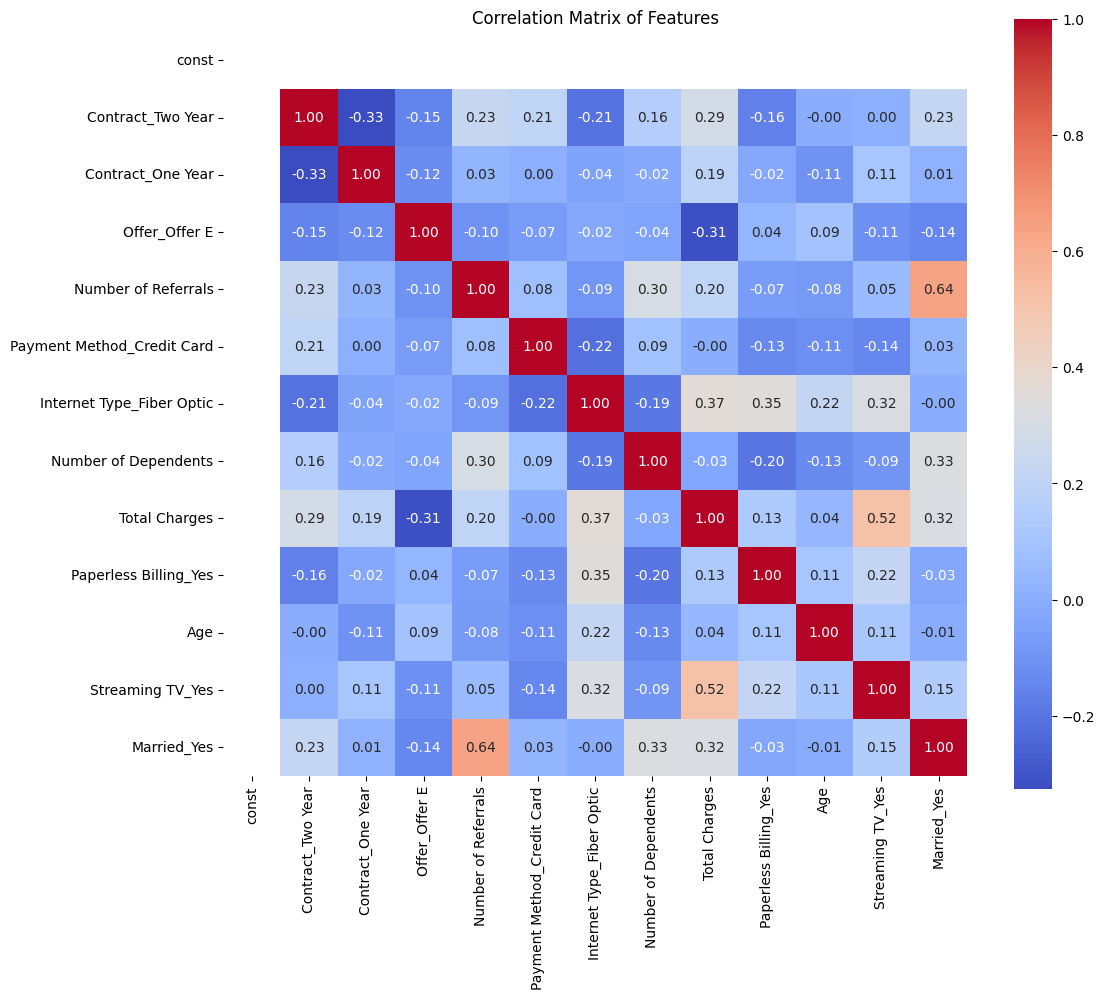

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creating a correlation matrix
correlation_matrix = X_train_sig_with_const.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Features')
plt.show()


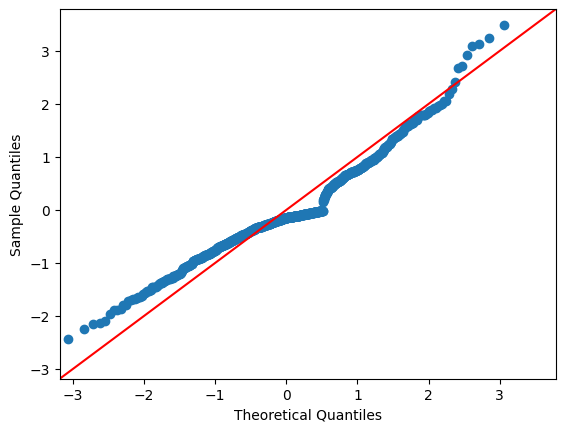

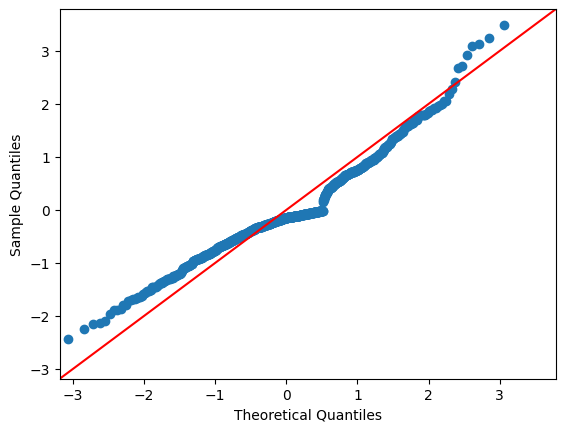

In [31]:
sm.qqplot(result.resid_dev, line='45')

## 4. Goodness of Fit

Null Hypothesis (H0): The model has a good fit (i.e., the deviance is not significantly different from a perfect fit model).

Alternative Hypothesis (H1): The model does not have a good fit.

In [ ]:
import numpy as np
from scipy.stats import chi2

# Recalculating the log-likelihood for the logistic regression model using the updated model
log_likelihood_train_updated = np.sum(np.log(result.predict(X_train_sig_with_const) ** y_train *
                                  (1 - result.predict(X_train_sig_with_const)) ** (1 - y_train)))
log_likelihood_test_updated = np.sum(np.log(result.predict(X_test_sig_with_const) ** y_test *
                                  (1 - result.predict(X_test_sig_with_const)) ** (1 - y_test)))

# Recalculating the deviance for the test set using the updated log-likelihood
deviance_test_updated = -2 * (log_likelihood_test_updated - log_likelihood_train_updated)

# Recalculating the degrees of freedom for the test set
# Number of predictors in the updated model plus 1 for the intercept
df_deviance_test_updated = X_test_sig_with_const.shape[0] - (X_test_sig_with_const.shape[1])

# Performing the Deviance Test (chi-square test) for the test set with the updated values
p_value_deviance_test_updated = 1 - chi2.cdf(deviance_test_updated, df_deviance_test_updated)

p_value_deviance_test_updated




The p-value is 1, meaning that the Deviance Test suggests the model has a good fit.

### Testing for Subsets of Coefficients (Full model vs Reduced Model)



Null Hypothesis: The Reduced Model is better (i.e., additional predictors in the Full Model do not significantly improve the model).
Alternative Hypothesis : The Full Model is better (i.e., additional predictors in the Full Model significantly improve the model).

In [34]:
# Add a constant to the training set for the intercept
X_train_full = sm.add_constant(X_train)

# Fit the logistic regression model
logit_model_full = sm.Logit(y_train, X_train_full)
result_full = logit_model_full.fit()

# Select only the features identified by Lasso regularization
significant_predictors = significant_features.index.tolist()
significant_predictors = [predictor for predictor in significant_predictors if predictor != 'const']

# Now select the data from X_train and X_test
X_train_sig = X_train[significant_predictors]
X_test_sig = X_test[significant_predictors]

# Re-train the model with the updated list of significant predictors
X_train_sig_with_const = sm.add_constant(X_train_sig)
X_test_sig_with_const = sm.add_constant(X_test_sig)

model_reduced = sm.Logit(y_train, X_train_sig_with_const)
result_reduced = model_reduced.fit()

# Perform the Likelihood Ratio test (LR test)
# LR statistic is -2 times the log-likelihood difference between models
lr_statistic = -2 * (result_reduced.llf - result_full.llf)

# Calculate the degrees of freedom for the LR test
# It's equal to the difference in the number of parameters between models
df = (len(result_full.params) - len(result_reduced.params))

# Performing the Deviance Test (chi-square test) for the LR test
p_value_lr_test = 1 - chi2.cdf(lr_statistic, df)

print(f"Likelihood Ratio Test Statistic: {lr_statistic:.2f}")
print(f"Degrees of Freedom: {df}")
print(f"P-Value (LR Test): {p_value_lr_test:.4f}")

Optimization terminated successfully.
         Current function value: 0.331445
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344021
         Iterations 8
Likelihood Ratio Test Statistic: 22.64
Degrees of Freedom: 18
P-Value (LR Test): 0.2050



Since the p-value (0.2050) is greater than the chosen significance level (e.g., 0.05), we do not have enough evidence to reject the null hypothesis. Therefore, we might conclude that the Reduced Model is sufficient.

## Scenario 2: Stepwise Regression

### Forward

In [35]:
from sklearn.feature_selection import SequentialFeatureSelector

# Creating a logistic regression model
log_reg = LogisticRegression()

# Setting up Sequential Feature Selector for forward selection
sfs = SequentialFeatureSelector(log_reg, direction='forward', cv=5)

# Fitting the selector to the training data
sfs.fit(X_train, y_train)

# Getting the selected features
forward_selected_features = X_train.columns[sfs.get_support()]

# Filter the selected features to include only statistically significant ones
selected_features = []

for feature in forward_selected_features:
    model = sm.Logit(y_train, sm.add_constant(X_train[feature]))
    result = model.fit()
    if result.pvalues[1] < 0.05:  # Adjust the significance level as needed
        selected_features.append(feature)

forward_selected_features_ = selected_features

print("Selected features:", forward_selected_features_)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_sequential.py:211: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


Optimization terminated successfully.
         Current function value: 0.612497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.607067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588165
  

In [36]:
# Add a constant to the predictor variable set to represent the intercept
X_train_updated_with_const = sm.add_constant(X_train[forward_selected_features_])
X_test_updated_with_const = sm.add_constant(X_test[forward_selected_features_])

# Fit the logistic regression model using statsmodels
model = sm.Logit(y_train, X_train_updated_with_const)
result = model.fit()

# Print the summary
print(result.summary2())

# Make predictions on the test data
predictions_prob_updated = result.predict(X_test_updated_with_const)
predictions_updated = np.where(predictions_prob_updated > 0.5, 1, 0)  # Convert probabilities to 0/1

# Calculate accuracy
accuracy_step = np.mean(predictions_updated == y_test)

# Calculate Recall
recall_step = recall_score(y_test, predictions_updated)

# Calculate AUC-ROC
auc_roc_step = roc_auc_score(y_test, predictions_prob_updated)

# Display the results
print(f"Recall: {recall_step:.2f}")
print(f"AUC-ROC: {auc_roc_step:.2f}")
print(f"Accuracy: {accuracy_step:.2f}")


Optimization terminated successfully.
         Current function value: 0.367348
         Iterations 8
                             Results: Logit
Model:                  Logit              Method:             MLE       
Dependent Variable:     Customer Status    Pseudo R-squared:   0.400     
Date:                   2024-01-03 08:56   AIC:                685.2256  
No. Observations:       900                BIC:                742.8544  
Df Model:               11                 Log-Likelihood:     -330.61   
Df Residuals:           888                LL-Null:            -551.46   
Converged:              1.0000             LLR p-value:        8.4127e-88
No. Iterations:         8.0000             Scale:              1.0000    
-------------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
const                     -1.7888   0.26

### Backward

In [37]:
# Setting up Sequential Feature Selector for backward selection
sbs = SequentialFeatureSelector(log_reg, direction='backward', cv=5)

# Fitting the selector to the training data
sbs.fit(X_train, y_train)

# Getting the selected features
backward_selected_features = X_train.columns[sfs.get_support()]

# Filter the selected features to include only statistically significant ones
selected_features = []

for feature in backward_selected_features:
    model = sm.Logit(y_train, sm.add_constant(X_train[feature]))
    result = model.fit()
    if result.pvalues[1] < 0.05:  # Adjust the significance level as needed
        selected_features.append(feature)

backward_selected_features_ = selected_features

print("Selected features:", backward_selected_features_)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_sequential.py:211: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


Optimization terminated successfully.
         Current function value: 0.612497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.607067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588165
  

In [38]:
# Add a constant to the predictor variable set to represent the intercept
X_train_backward_with_const = sm.add_constant(X_train[backward_selected_features_])
X_test_backward_with_const = sm.add_constant(X_test[backward_selected_features_])

# Fit the logistic regression model using statsmodels
model_backward = sm.Logit(y_train, X_train_backward_with_const)
result_backward = model_backward.fit()

# Print the summary
print(result_backward.summary2())

# Make predictions on the test data
predictions_prob_backward = result_backward.predict(X_test_backward_with_const)
predictions_backward = np.where(predictions_prob_backward > 0.5, 1, 0)  # Convert probabilities to 0/1

# Calculate accuracy
accuracy_backward = np.mean(predictions_backward == y_test)

# Calculate Recall
recall_backward = recall_score(y_test, predictions_backward)

# Calculate AUC-ROC
auc_roc_backward = roc_auc_score(y_test, predictions_prob_backward)

# Display the results
print(f"Recall: {recall_backward:.2f}")
print(f"AUC-ROC: {auc_roc_backward:.2f}")
print(f"Accuracy: {accuracy_backward:.2f}")

Optimization terminated successfully.
         Current function value: 0.367348
         Iterations 8
                             Results: Logit
Model:                  Logit              Method:             MLE       
Dependent Variable:     Customer Status    Pseudo R-squared:   0.400     
Date:                   2024-01-03 08:57   AIC:                685.2256  
No. Observations:       900                BIC:                742.8544  
Df Model:               11                 Log-Likelihood:     -330.61   
Df Residuals:           888                LL-Null:            -551.46   
Converged:              1.0000             LLR p-value:        8.4127e-88
No. Iterations:         8.0000             Scale:              1.0000    
-------------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
const                     -1.7888   0.26

Both methods (forward, backward) share the same variables with almost the same predictive power metrics

Therefore, based on the provided performance metrics, it's challenging to determine a clear winner between the two models


In [39]:
# Add a constant to the features for VIF computation
X_train_backward_with_const = sm.add_constant(X_train[backward_selected_features_])

# Calculating VIF for each feature
vif_data_backward = pd.DataFrame()
vif_data_backward['Feature'] = X_train_backward_with_const.columns
vif_data_backward['VIF'] = [variance_inflation_factor(X_train_backward_with_const.values, i) for i in range(X_train_backward_with_const.shape[1])]

# Sort the VIF data in descending order
vif_data_backward_sorted = vif_data_backward.sort_values(by='VIF', ascending=False)

# Filter features with VIF less than 50 (you can adjust this threshold as needed)
vif_data_backward_filtered = vif_data_backward[vif_data_backward['VIF'] < 50]


print("\nVIF Data (Filtered by VIF < 50):")
print(vif_data_backward_filtered)



VIF Data (Filtered by VIF < 50):
                      Feature       VIF
0                       const  6.381831
1                 Married_Yes  1.765014
2               Offer_Offer A  1.192688
3               Offer_Offer B  1.085898
4               Offer_Offer E  1.095149
5   Internet Type_Fiber Optic  1.344712
6        Streaming Movies_Yes  1.182590
7           Contract_One Year  1.269852
8           Contract_Two Year  1.513048
9       Paperless Billing_Yes  1.173991
10                        Age  1.091238
11        Number of Referrals  1.733193


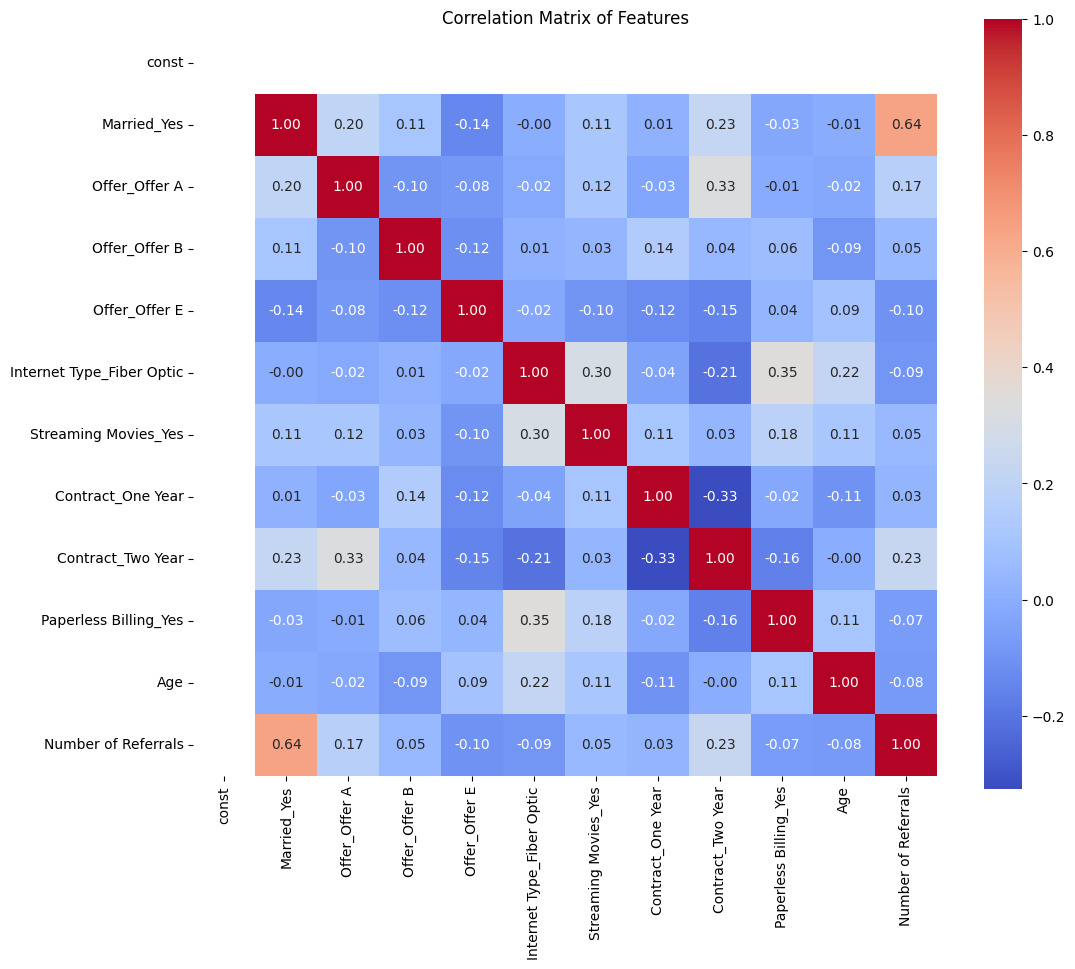

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creating a correlation matrix
correlation_matrix = X_train_backward_with_const.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Features')
plt.show()

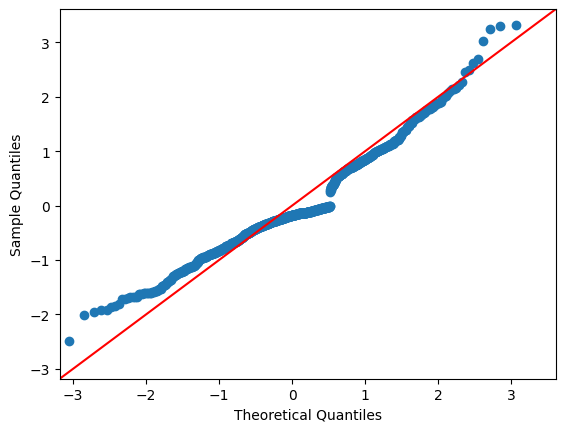

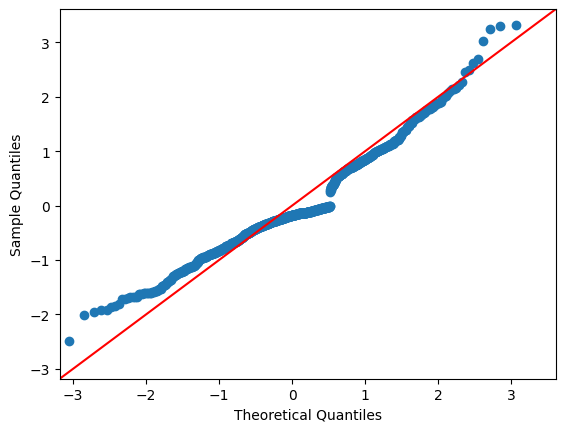

In [41]:
sm.qqplot(result_backward.resid_dev, line='45')

### Goodness of Fit

In [42]:
import numpy as np
from scipy.stats import chi2

# Recalculating the log-likelihood for the logistic regression model using the updated model
log_likelihood_train_backward = np.sum(np.log(result_backward.predict(X_train_backward_with_const) ** y_train *
                                  (1 - result_backward.predict(X_train_backward_with_const)) ** (1 - y_train)))
log_likelihood_test_backward = np.sum(np.log(result_backward.predict(X_test_backward_with_const) ** y_test *
                                  (1 - result_backward.predict(X_test_backward_with_const)) ** (1 - y_test)))

# Recalculating the deviance for the test set using the updated log-likelihood
deviance_test_backward = -2 * log_likelihood_test_backward

# Recalculating the degrees of freedom for the test set
# Number of predictors in the updated model plus 1 for the intercept
df_deviance_test_backward = X_test_backward_with_const.shape[0] - (X_test_backward_with_const.shape[1])

# Performing the Deviance Test (chi-square test) for the test set with the updated values
p_value_deviance_test_backward = 1 - chi2.cdf(deviance_test_backward, df_deviance_test_backward)

p_value_deviance_test_backward


0.9937718838391415

### Testing for Subsets of Coefficients (Full model vs Reduced Model)


In [43]:
# Add a constant to the training set for the intercept
X_train_full = sm.add_constant(X_train)

# Fit the logistic regression model for the full set of predictors
logit_model_full = sm.Logit(y_train, X_train_full)
result_full = logit_model_full.fit()

# Create a list of significant predictors from the Stepwise Backward model
significant_predictors = backward_selected_features_

# Now select the data from X_train and X_test based on the significant predictors
X_train_sig = X_train[significant_predictors]
X_test_sig = X_test[significant_predictors]

# Add a constant to the selected predictor set for the intercept
X_train_sig_with_const = sm.add_constant(X_train_sig)
X_test_sig_with_const = sm.add_constant(X_test_sig)

# Fit the logistic regression model with the selected predictors
model_reduced = sm.Logit(y_train, X_train_sig_with_const)
result_reduced = model_reduced.fit()

# Perform the Likelihood Ratio test (LR test)
# LR statistic is -2 times the log-likelihood difference between models
lr_statistic = -2 * (result_reduced.llf - result_full.llf)

# Calculate the degrees of freedom for the LR test
# It's equal to the difference in the number of parameters between models
df = (len(result_full.params) - len(result_reduced.params))

# Performing the Deviance Test (chi-square test) for the LR test
p_value_lr_test = 1 - chi2.cdf(lr_statistic, df)

print(f"Likelihood Ratio Test Statistic: {lr_statistic:.2f}")
print(f"Degrees of Freedom: {df}")
print(f"P-Value (LR Test): {p_value_lr_test:.4f}")


Optimization terminated successfully.
         Current function value: 0.331445
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367348
         Iterations 8
Likelihood Ratio Test Statistic: 64.62
Degrees of Freedom: 19
P-Value (LR Test): 0.0000


the P-Value for the LR Test is 0, which is less than 0.05. This indicates that there is strong evidence to reject the null hypothesis and conclude that the full model (with all predictors) is a significantly better fit for the data than the reduced model (Stepwise Backward Logistic Regression Model).

## Comparing Two models (Accuracy, recall, AUC-ROC)

In [44]:
# Example metrics for three models (adjust the values as per your actual results)
model_metrics = [
    {"Model": "Logistic Regression Model(lasso)", "Accuracy": accuracy_lasso, "Recall": recall_lasso, "AUC-ROC": auc_roc_lasso},
    {"Model": "Logistic Regression Model(stepwise)", "Accuracy": accuracy_backward, "Recall": recall_backward, "AUC-ROC": auc_roc_backward},
]

# Convert the list of dictionaries to a DataFrame
metrics_df = pd.DataFrame(model_metrics)

# Display the DataFrame
metrics_df

Model  Accuracy    Recall   AUC-ROC
0     Logistic Regression Model(lasso)  0.843333  0.714286  0.910142
1  Logistic Regression Model(stepwise)  0.826667  0.692308  0.888164

 Both models have similar accuracy and AUC-ROC values. However, the logistic regression model with Lasso regularization (lasso) has a slightly higher accuracy (0.8433 vs. 0.8267) and a slightly higher recall (0.7143 vs. 0.6923) compared to the logistic regression model with stepwise feature selection (stepwise). Based on these metrics alone, the Lasso model seems to perform slightly better.


## Conclusion

In [45]:
print(result_lasso.summary2())


                              Results: Logit
Model:                 Logit               Method:              MLE       
Dependent Variable:    Customer Status     Pseudo R-squared:    0.439     
Date:                  2024-01-03 08:57    AIC:                 645.2370  
No. Observations:      900                 BIC:                 707.6682  
Df Model:              12                  Log-Likelihood:      -309.62   
Df Residuals:          887                 LL-Null:             -551.46   
Converged:             1.0000              LLR p-value:         6.5505e-96
No. Iterations:        8.0000              Scale:               1.0000    
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
const                      -2.0213   0.3352 -6.0302 0.0000 -2.6783 -1.3643
Contract_Two Year          -2.8535   0.4484 -6.3639 0.0

The model has selected 12 predictors that are considered statistically significant. These predictors are associated with customer churn, and their coefficients provide insights into the direction and strength of the relationships. Notable predictors include:



1.   Contract type (Two Year and One Year): Customers with longer contract durations (Two Year and One Year) are less likely to churn, as indicated by negative coefficients.
2.   Offer type (Offer E): Customers targeted with Offer E are more likely to churn, as indicated by a positive coefficient.
3.   Number of referrals: More referrals are associated with a lower likelihood of churn (negative coefficient).
4.   Payment Method (Credit Card): Customers using credit card payment methods are less likely to churn (negative coefficient).
5.   Internet Type (Fiber Optic): Customers with Fiber Optic internet are more likely to churn (positive coefficient).

Longer contracts may provide customers with more stability and commitment, making them less likely to switch to a different service provider. It's common for businesses to offer incentives, discounts, or special deals to encourage customers to commit to longer contracts as a way to reduce churn.

## Tuning and Optimization

Best Accuracy: 0.85 at Threshold: 0.43


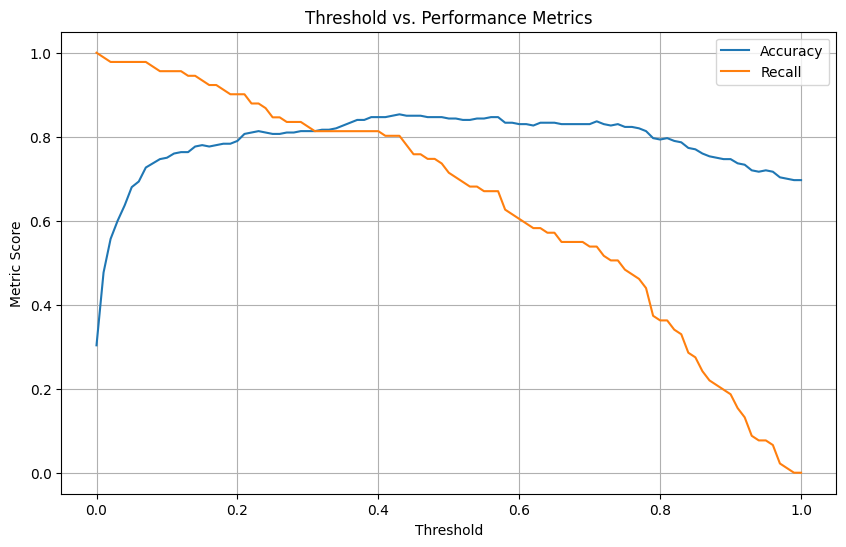

In [46]:
thresholds = np.arange(0, 1.01, 0.01)  # Define a range of thresholds from 0 to 1
accuracy_scores = []
recall_scores = []

for threshold in thresholds:
    # Apply the threshold to predicted probabilities
    binary_predictions = np.where(predictions_prob_lasso > threshold, 1, 0)

    # Calculate accuracy and recall for each threshold
    accuracy = np.mean(binary_predictions == y_test)
    recall = recall_score(y_test, binary_predictions)

    accuracy_scores.append(accuracy)
    recall_scores.append(recall)

# Find the threshold that maximizes recall
best_recall_threshold = thresholds[np.argmax(recall_scores)]
max_recall = max(recall_scores)

# Find the threshold that maximizes accuracy
best_accuracy_threshold = thresholds[np.argmax(accuracy_scores)]
max_accuracy = max(accuracy_scores)

print(f"Best Accuracy: {max_accuracy:.2f} at Threshold: {best_accuracy_threshold:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy_scores, label='Accuracy')
plt.plot(thresholds, recall_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Metric Score')
plt.legend()
plt.title('Threshold vs. Performance Metrics')
plt.grid(True)
plt.show()

In [47]:
# find where accuracy and recall intersect
idx = np.argwhere(np.diff(np.sign(np.array(accuracy_scores) - np.array(recall_scores)))).flatten()
print(f"Best threshold: {thresholds[idx]} with an accuracy of {np.array(accuracy_scores)[idx]} and recall of {np.array(recall_scores)[idx]}")

Best threshold: [0.3] with an accuracy of [0.81333333] and recall of [0.82417582]


### Refitting the model with the optimal threshold

In [48]:
# Select only the features identified by Lasso regularization
significant_predictors = significant_features.index.tolist()
significant_predictors = [predictor for predictor in significant_predictors if predictor != 'const']



# Now select the data from X_train and X_test
X_train_sig = X_train[significant_predictors]
X_test_sig = X_test[significant_predictors]



# Re-train the model with the updated list of significant predictors
X_train_sig_with_const = sm.add_constant(X_train_sig)
X_test_sig_with_const = sm.add_constant(X_test_sig)

model = sm.Logit(y_train, X_train_sig_with_const)
result_lasso = model.fit()
print(result_lasso.summary2())


# Make predictions on the test data
predictions_prob_lasso = result_lasso.predict(X_test_sig_with_const)
predictions_lasso = np.where(predictions_prob_lasso > 0.43, 1, 0)  # Convert probabilities to 0/1 and applied 0.43

# Calculate accuracy
accuracy_lasso = np.mean(predictions_lasso == y_test)

# Calculate Recall
recall_lasso = recall_score(y_test, predictions_lasso)

# Calculate AUC-ROC
auc_roc_lasso = roc_auc_score(y_test, predictions_prob_lasso)

print(f"Recall: {recall_lasso:.2f}")
print(f"AUC-ROC: {auc_roc_lasso:.2f}")

print(f"Accuracy: {accuracy_lasso:.2f}")

Optimization terminated successfully.
         Current function value: 0.344021
         Iterations 8
                              Results: Logit
Model:                 Logit               Method:              MLE       
Dependent Variable:    Customer Status     Pseudo R-squared:    0.439     
Date:                  2024-01-03 08:57    AIC:                 645.2370  
No. Observations:      900                 BIC:                 707.6682  
Df Model:              12                  Log-Likelihood:      -309.62   
Df Residuals:          887                 LL-Null:             -551.46   
Converged:             1.0000              LLR p-value:         6.5505e-96
No. Iterations:        8.0000              Scale:               1.0000    
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
const                      -

The Recall improved significantly!

## Model Validation

In [49]:
# Select only the features identified by Lasso regularization
significant_predictors = significant_features.index.tolist()
significant_predictors = [predictor for predictor in significant_predictors if predictor != 'const']

# Select the data from X_val
X_val_sig = X_val[significant_predictors]

# Add a constant to the validation dataset for the intercept
X_val_sig_with_const = sm.add_constant(X_val_sig)

# Use the previously trained Lasso Logistic Regression model to make predictions on the validation data
predictions_prob_val = result_lasso.predict(X_val_sig_with_const)
predictions_val = np.where(predictions_prob_val > 0.43, 1, 0)  # Convert probabilities to 0/1

# Calculate accuracy on the validation data
accuracy_val = np.mean(predictions_val == y_val)

# Calculate Recall on the validation data
recall_val = recall_score(y_val, predictions_val)

# Calculate AUC-ROC on the validation data
auc_roc_val = roc_auc_score(y_val, predictions_prob_val)

# Display the validation results
print("Validation Results:")
print(f"Recall: {recall_val:.2f}")
print(f"AUC-ROC: {auc_roc_val:.2f}")
print(f"Accuracy: {accuracy_val:.2f}")

Validation Results:
Recall: 0.70
AUC-ROC: 0.89
Accuracy: 0.81
